In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import torch 

import torch.nn as nn 

from evaluation import get_actual_demand, get_known

from utils import load_problem_data

from lstm_model import LSTM

In [3]:
demand, _ , _ , _= load_problem_data() ##pd.read_csv('./data/demand.csv')
demand

server_type = "CPU.S1"
latency_sensitivity = "low"

lookback = 25
lookahead = 10

seeds = range(0,10000,100)



In [4]:
def getSeedDemand(seed):
    

    ## set random seed for numpy
    np.random.seed(seed)

    # get the demand under this seed
    seeded_demand = get_actual_demand(demand)



    ## only get rows for this server type
    seeded_demand = seeded_demand.loc[    (seeded_demand["server_generation"]== server_type)]

    seeded_demand = seeded_demand.reset_index()

    ## remove all other rows, apart from the latency_sensitivity we are interested in 
    seeded_demand = seeded_demand[ [   latency_sensitivity ] ]


    seeded_demand.index.names = ['time_step']



    ## add in missing values for timestep
    for t in range(get_known("time_steps")):
        if t not in seeded_demand.index:
            seeded_demand.loc[t,latency_sensitivity] = 0




    ## add zeroes for lookback values before 0, so we can predict something for the first timesteps
    for t in range(0,-lookback,-1):
        seeded_demand.loc[t,latency_sensitivity] = 0

    ## add zeroes for lookahead values before 0, so we can predict something for the last timesteps
    for t in range(lookahead):
        seeded_demand.loc[get_known("time_steps")+t,latency_sensitivity] = 0


    seeded_demand = seeded_demand.sort_index()

    return seeded_demand

data = getSeedDemand(0)
data

latency_sensitivity  low
time_step               
-24                  0.0
-23                  0.0
-22                  0.0
-21                  0.0
-20                  0.0
...                  ...
 173                 0.0
 174                 0.0
 175                 0.0
 176                 0.0
 177                 0.0

[202 rows x 1 columns]

In [5]:
## set device to gpu if possible
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
from copy import deepcopy as dc

## get dataframe with past and future values for demand
def prepare_dataframe_for_lstm(df, back_steps, forward_steps):
    df = dc(df)


    for i in range(1, forward_steps):
        df[f'{latency_sensitivity}(t+{i})'] = df[latency_sensitivity].shift(-i)

    for i in range(1, back_steps+1):
        df[f'{latency_sensitivity}(t-{i})'] = df[latency_sensitivity].shift(i)

    
    

    df.dropna(inplace=True)

    return df

prepare_dataframe_for_lstm(data,lookback,lookahead)

latency_sensitivity       low  low(t+1)  low(t+2)  low(t+3)  low(t+4)  \
time_step                                                               
1                     36978.0   42060.0   57856.0   75595.0  117348.0   
2                     42060.0   57856.0   75595.0  117348.0  113683.0   
3                     57856.0   75595.0  117348.0  113683.0  116486.0   
4                     75595.0  117348.0  113683.0  116486.0   98307.0   
5                    117348.0  113683.0  116486.0   98307.0   96211.0   
...                       ...       ...       ...       ...       ...   
164                       0.0       0.0       0.0       0.0       0.0   
165                       0.0       0.0       0.0       0.0       0.0   
166                       0.0       0.0       0.0       0.0       0.0   
167                       0.0       0.0       0.0       0.0       0.0   
168                       0.0       0.0       0.0       0.0       0.0   

latency_sensitivity  low(t+5)  low(t+6)  low(t+7)  low(t+8)  low(t+9)  ...  \
time_step                                                              ...   
1                    113683.0  116486.0   98307.0   96211.0  111444.0  ...   
2                    116486.0   98307.0   96211.0  111444.0  105191.0  ...   
3                     98307.0   96211.0  111444.0  105191.0   99385.0  ...   
4                     96211.0  111444.0  105191.0   99385.0   67802.0  ...   
5                    111444.0  105191.0   99385.0   67802.0   70026.0  ...   
...                       ...       ...       ...       ...       ...  ...   
164                       0.0       0.0       0.0       0.0       0.0  ...   
165                       0.0       0.0       0.0       0.0       0.0  ...   
166                       0.0       0.0       0.0       0.0       0.0  ...   
167                       0.0       0.0       0.0       0.0       0.0  ...   
168                       0.0       0.0       0.0       0.0       0.0  ...   

latency_sensitivity  low(t-16)  low(t-17)  low(t-18)  low(t-19)  low(t-20)  \
time_step                                                                    
1                          0.0        0.0        0.0        0.0        0.0   
2                          0.0        0.0        0.0        0.0        0.0   
3                          0.0        0.0        0.0        0.0        0.0   
4                          0.0        0.0        0.0        0.0        0.0   
5                          0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
164                        0.0        0.0        0.0        0.0        0.0   
165                        0.0        0.0        0.0        0.0        0.0   
166                        0.0        0.0        0.0        0.0        0.0   
167                        0.0        0.0        0.0        0.0        0.0   
168                        0.0        0.0        0.0        0.0        0.0   

latency_sensitivity  low(t-21)  low(t-22)  low(t-23)  low(t-24)  low(t-25)  
time_step                                                                   
1                          0.0        0.0        0.0        0.0        0.0  
2                          0.0        0.0        0.0        0.0        0.0  
3                          0.0        0.0        0.0        0.0        0.0  
4                          0.0        0.0        0.0        0.0        0.0  
5                          0.0        0.0        0.0        0.0        0.0  
...                        ...        ...        ...        ...        ...  
164                        0.0        0.0        0.0        0.0        0.0  
165                        0.0        0.0        0.0        0.0        0.0  
166                        0.0        0.0        0.0        0.0        0.0  
167                        0.0        0.0        0.0        0.0        0.0  
168                        0.0        0.0        0.0        0.0        0.0  

[168 rows x 35 col

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = None

def getDataNumpyArray(seed):

    data = getSeedDemand(seed)

    shifted_df = prepare_dataframe_for_lstm(data, lookback, lookahead)

    shifted_df_as_np = shifted_df.to_numpy()

    global scaler

    scaler = MinMaxScaler(feature_range=(-1,1))

    # scaler = StandardScaler()


    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

    X = shifted_df_as_np[:, lookahead:]

    Y = shifted_df_as_np[:,:lookahead]

    ## flip matrix, so values further in the past, come first in the matrix
    X = dc(np.flip(X,axis=1))


    ## flip matrix, so values further in the past, come first in the matrix
    X = dc(np.flip(X,axis=1))

    X = X.reshape( (-1, lookback, 1) )

    Y = Y.reshape( (-1, lookahead, 1) )

    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()

    return X,Y



    





    

In [31]:
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):


    def __init__(self, data):
        
        self.data = data
        

    
    def __len__(self):
        


        return len(self.data) * len(self.data[0][0])
    
    


    def __getitem__(self, i ):

        timeseries = i // len(self.data[0][0])

        row = i % len(self.data[0][0])

      

        return self.data[timeseries][0][row], self.data[timeseries][1][row]





In [32]:
# class LSTM(nn.Module):

#     def __init__(self, input_size, hidden_size, num_stacked_layers, lookahead):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_stacked_layers = num_stacked_layers

#         self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
#                             batch_first=True)

#         self.fc = nn.Linear(hidden_size, lookahead)



#     def forward(self, x):
#         batch_size = x.size(0)
#         h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out



In [33]:
def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        output = torch.unsqueeze(output,2)
       
        
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print('EPOCH {0}, Loss: {1:.3f}'.format(epoch+1,
                                            running_loss))
            
    print()

CPU.S1 high
EPOCH 1, Loss: 262.727

EPOCH 2, Loss: 98.712

EPOCH 3, Loss: 86.512

EPOCH 4, Loss: 80.540

EPOCH 5, Loss: 76.314

EPOCH 6, Loss: 73.759

EPOCH 7, Loss: 72.465

EPOCH 8, Loss: 71.757

EPOCH 9, Loss: 71.296

EPOCH 10, Loss: 70.936

R2: 0.7612009644508362
0


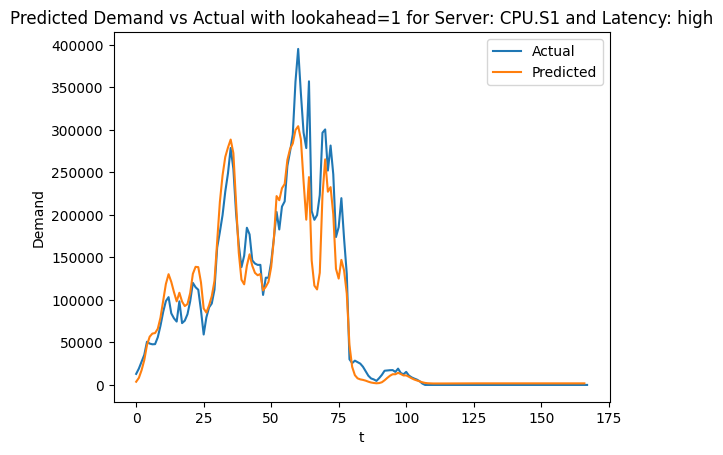

3


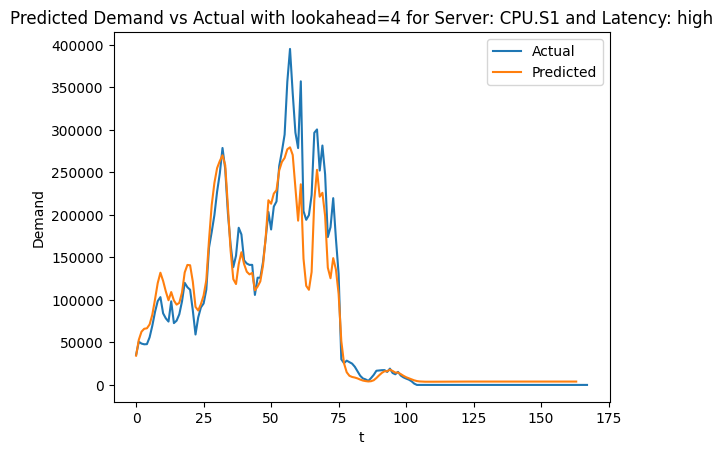

6


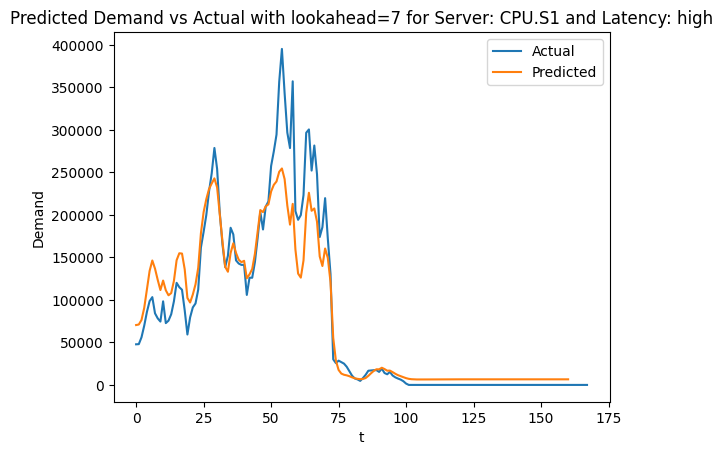

9


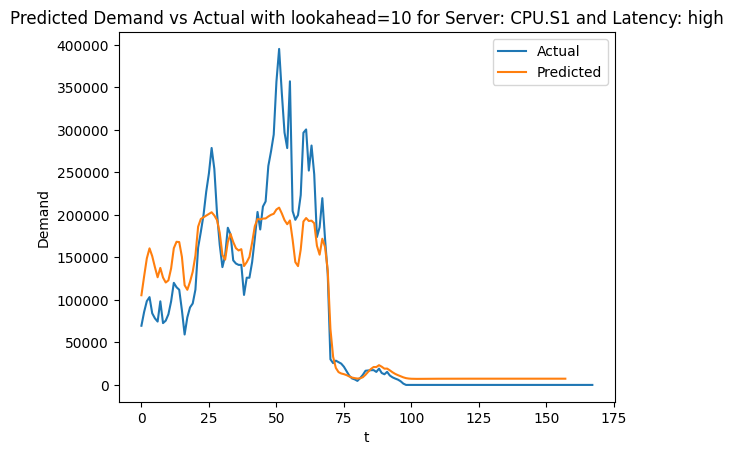

CPU.S1 medium
EPOCH 1, Loss: 275.885

EPOCH 2, Loss: 118.563

EPOCH 3, Loss: 103.786

EPOCH 4, Loss: 96.165

EPOCH 5, Loss: 90.383

EPOCH 6, Loss: 84.761

EPOCH 7, Loss: 81.274

EPOCH 8, Loss: 79.592

EPOCH 9, Loss: 78.422

EPOCH 10, Loss: 77.507

R2: 0.7365848422050476
0


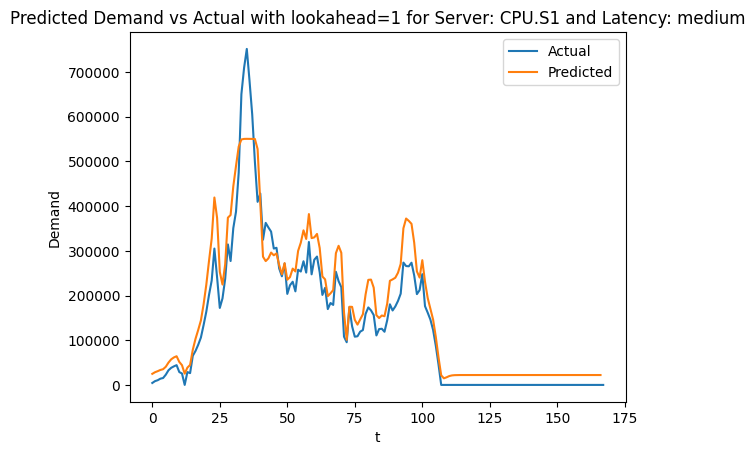

3


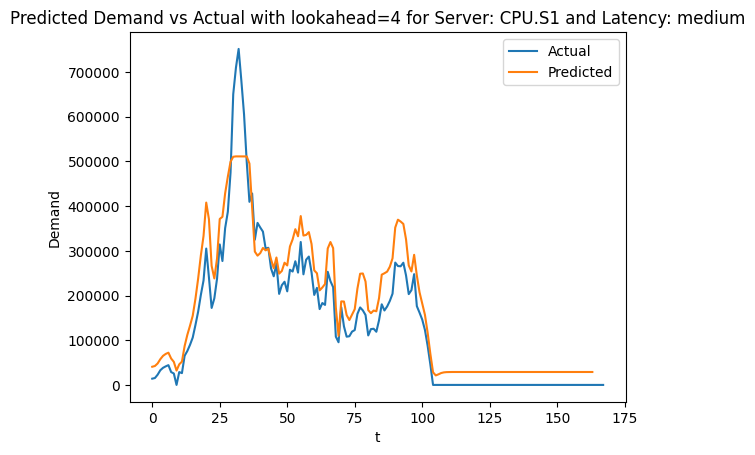

6


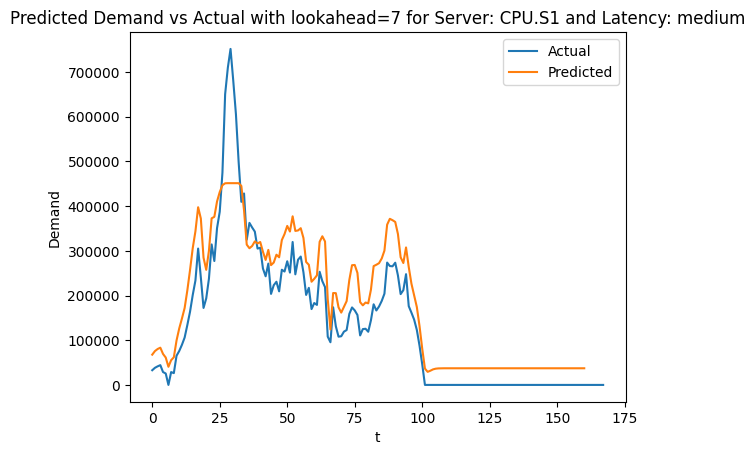

9


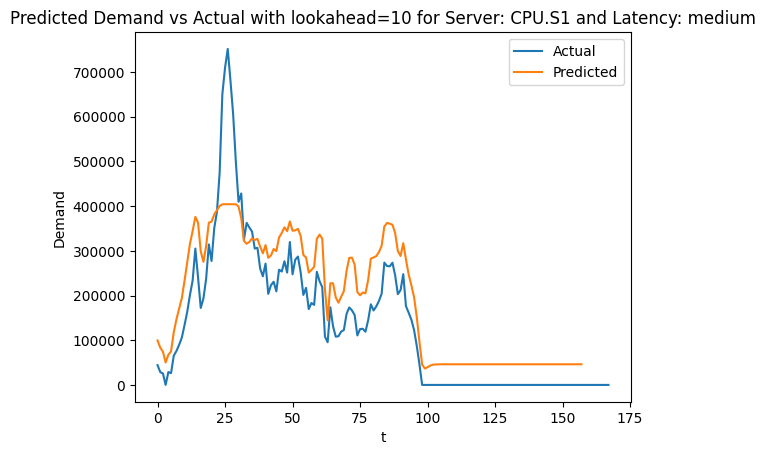

CPU.S1 low
EPOCH 1, Loss: 284.617

EPOCH 2, Loss: 111.399

EPOCH 3, Loss: 92.463

EPOCH 4, Loss: 86.743

EPOCH 5, Loss: 84.279

EPOCH 6, Loss: 83.050

EPOCH 7, Loss: 82.302

EPOCH 8, Loss: 81.773

EPOCH 9, Loss: 81.360

EPOCH 10, Loss: 81.017

R2: 0.7454599142074585
0


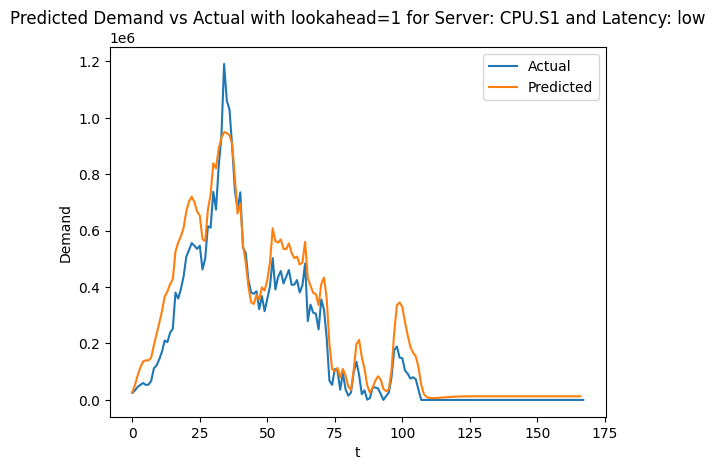

3


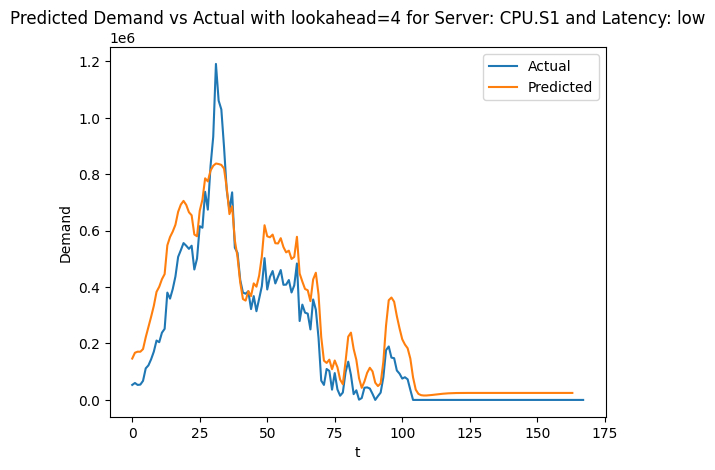

6


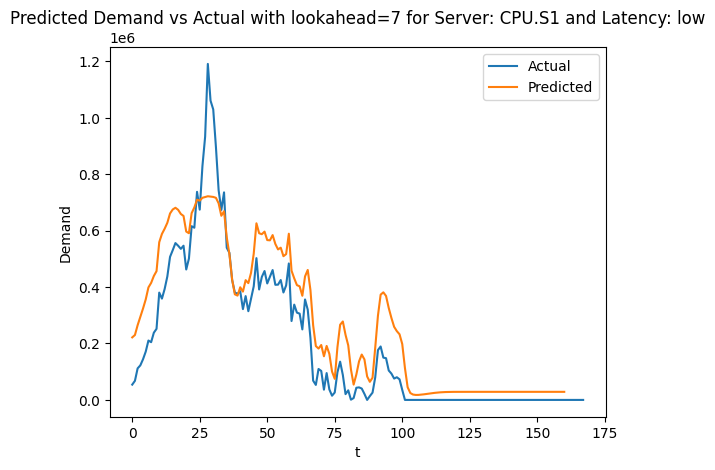

9


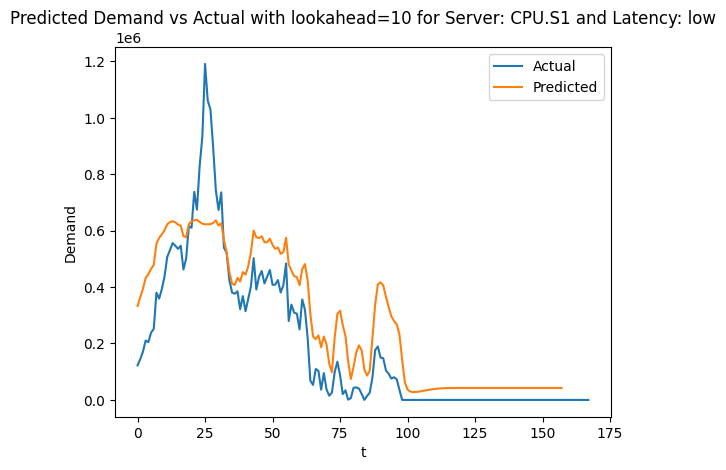

CPU.S2 high
EPOCH 1, Loss: 257.236

EPOCH 2, Loss: 97.007

EPOCH 3, Loss: 83.587

EPOCH 4, Loss: 80.637

EPOCH 5, Loss: 78.957

EPOCH 6, Loss: 77.716

EPOCH 7, Loss: 76.635

EPOCH 8, Loss: 75.519

EPOCH 9, Loss: 74.283

EPOCH 10, Loss: 72.861

R2: 0.7995743751525879
0


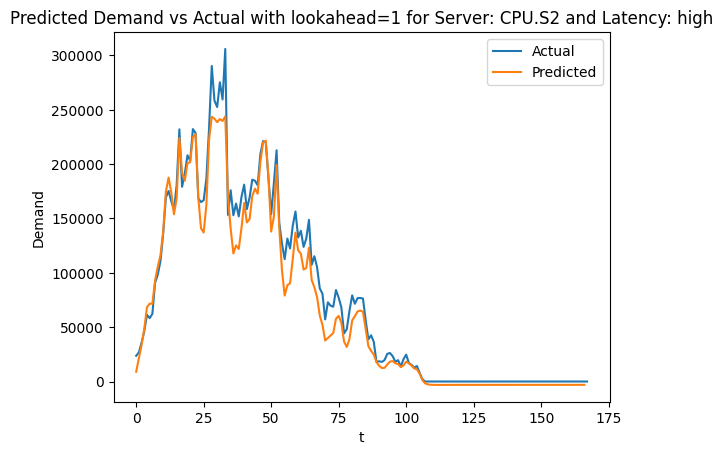

3


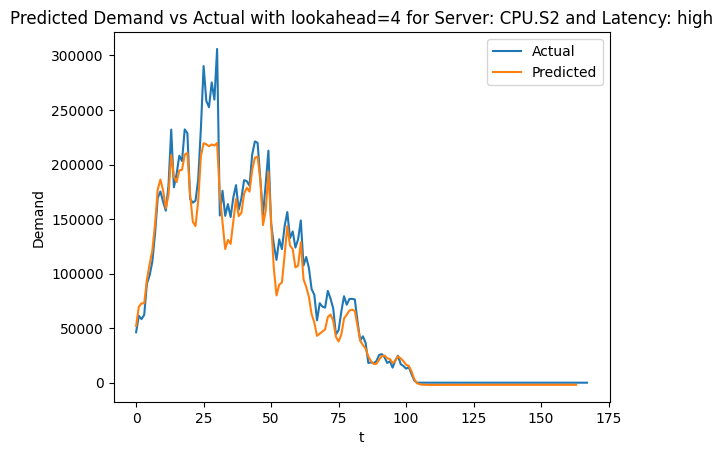

6


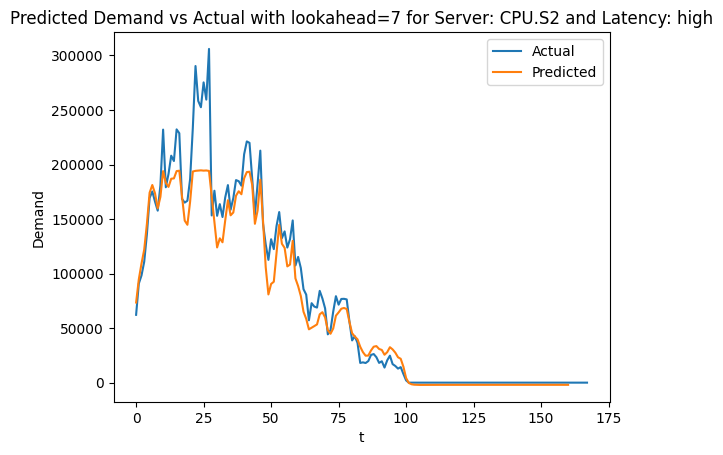

9


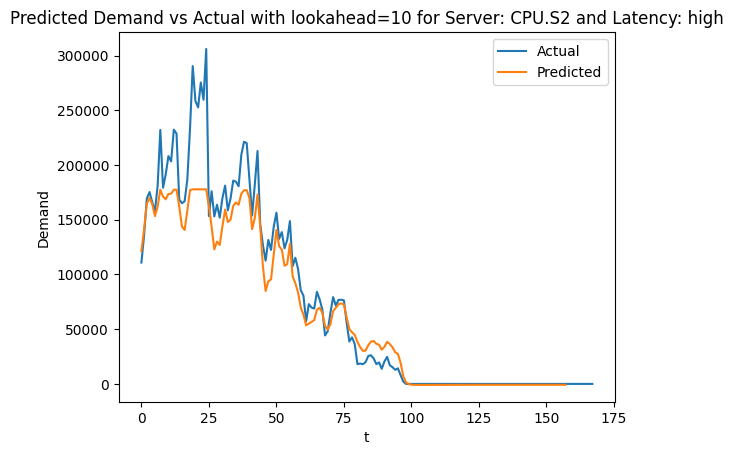

CPU.S2 medium
EPOCH 1, Loss: 315.016

EPOCH 2, Loss: 117.868

EPOCH 3, Loss: 87.158

EPOCH 4, Loss: 80.450

EPOCH 5, Loss: 76.822

EPOCH 6, Loss: 74.067

EPOCH 7, Loss: 71.967

EPOCH 8, Loss: 70.552

EPOCH 9, Loss: 69.628

EPOCH 10, Loss: 68.971

R2: 0.8096687197685242
0


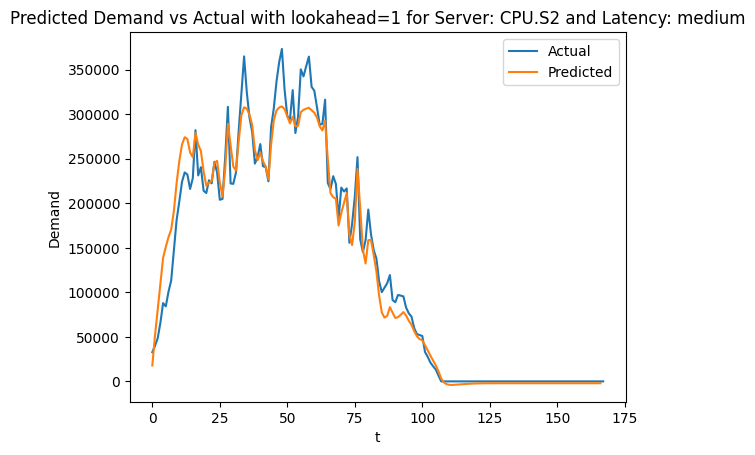

3


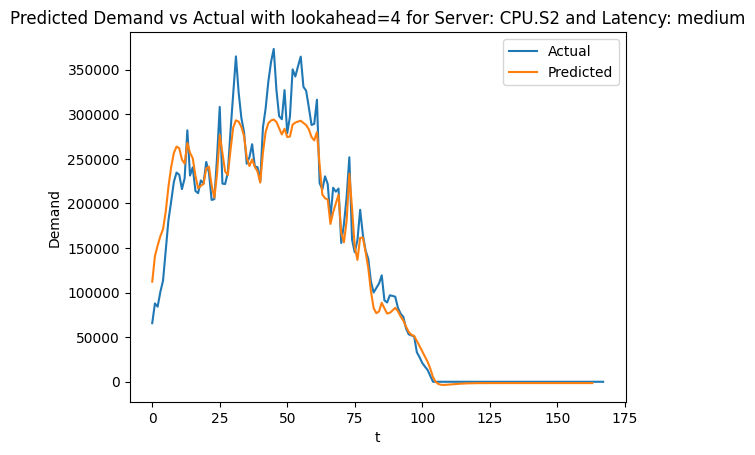

6


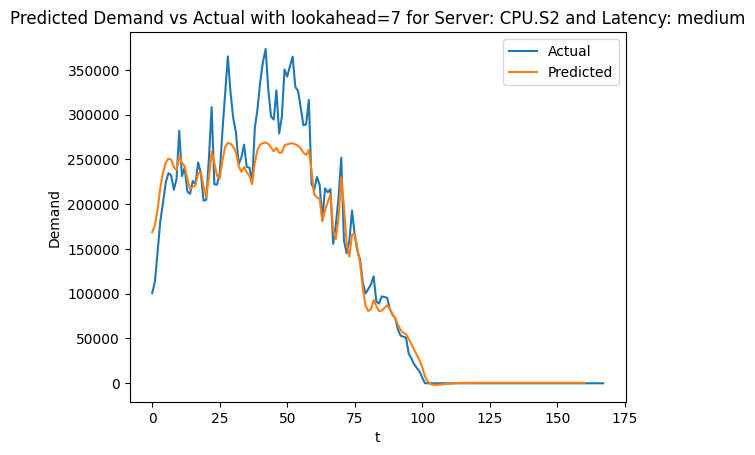

9


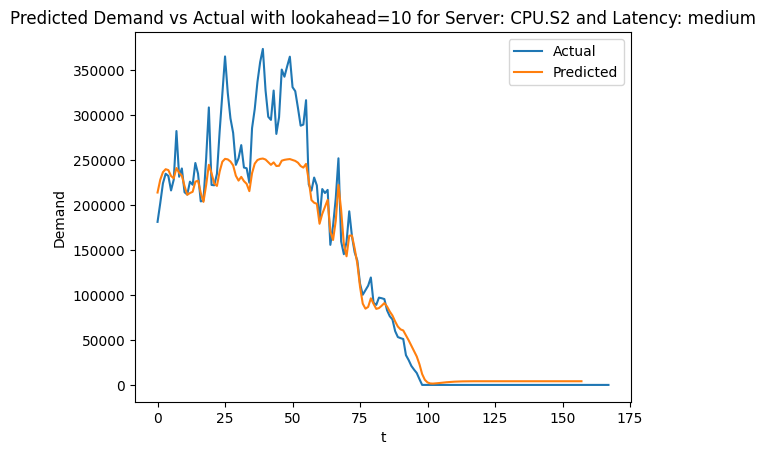

CPU.S2 low
EPOCH 1, Loss: 271.712

EPOCH 2, Loss: 120.920

EPOCH 3, Loss: 98.793

EPOCH 4, Loss: 89.912

EPOCH 5, Loss: 86.071

EPOCH 6, Loss: 84.155

EPOCH 7, Loss: 82.929

EPOCH 8, Loss: 82.012

EPOCH 9, Loss: 81.257

EPOCH 10, Loss: 80.583

R2: 0.8046596646308899
0


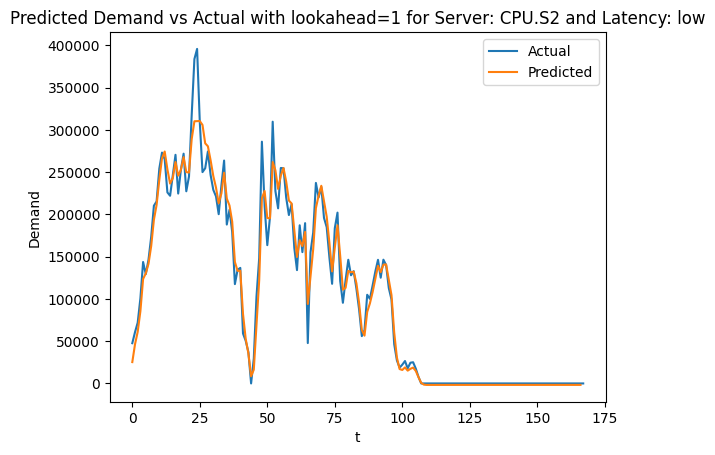

3


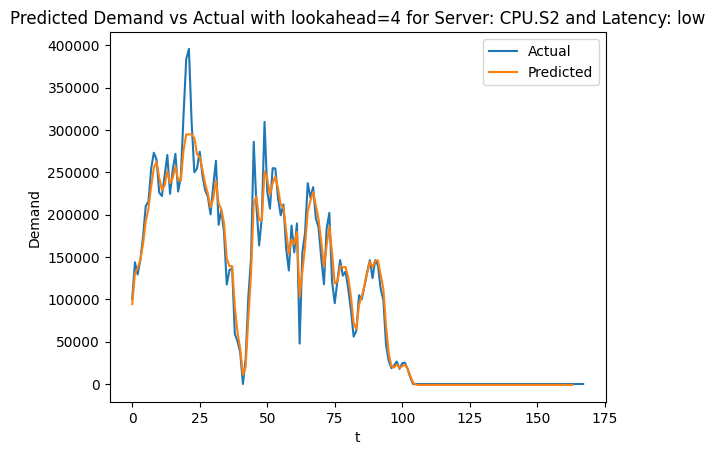

6


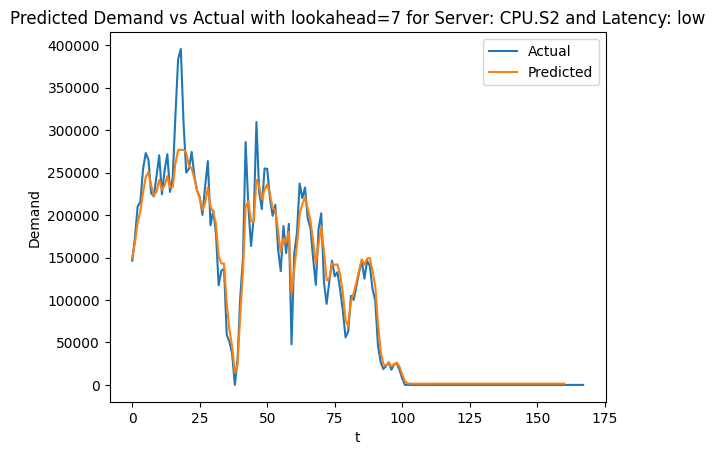

9


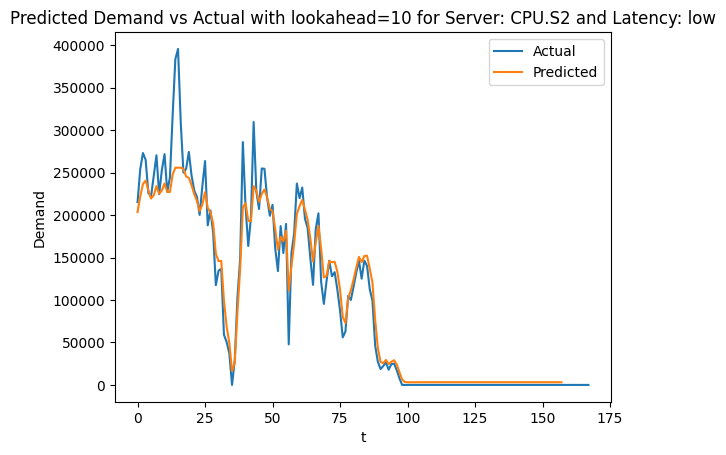

CPU.S3 high
EPOCH 1, Loss: 283.181

EPOCH 2, Loss: 130.570

EPOCH 3, Loss: 117.032

EPOCH 4, Loss: 110.361

EPOCH 5, Loss: 105.745

EPOCH 6, Loss: 103.173

EPOCH 7, Loss: 101.584

EPOCH 8, Loss: 100.421

EPOCH 9, Loss: 99.856

EPOCH 10, Loss: 99.334

R2: 0.7574557065963745
0


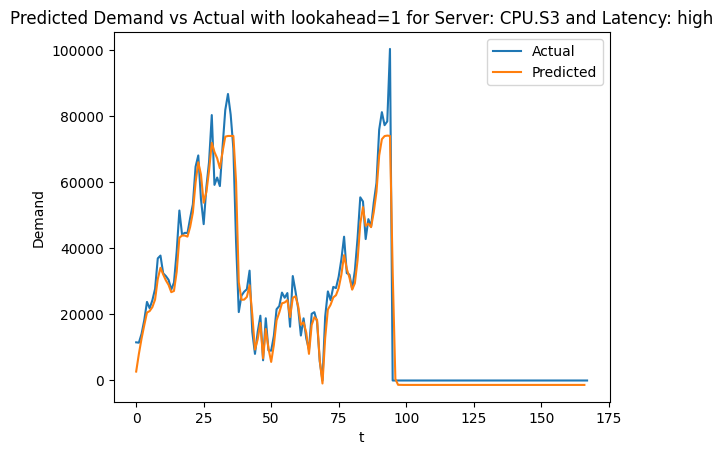

3


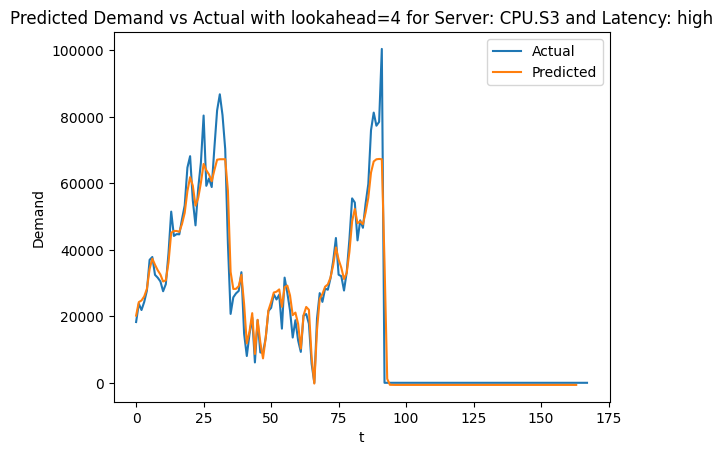

6


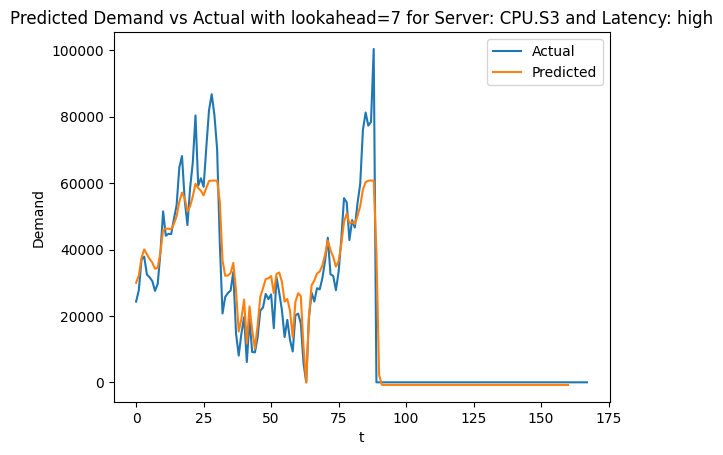

9


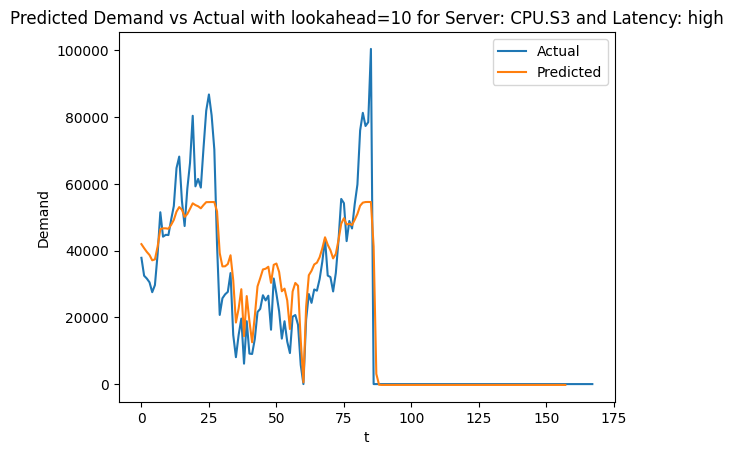

CPU.S3 medium
EPOCH 1, Loss: 313.265

EPOCH 2, Loss: 136.585

EPOCH 3, Loss: 108.546

EPOCH 4, Loss: 102.457

EPOCH 5, Loss: 100.543

EPOCH 6, Loss: 99.493

EPOCH 7, Loss: 98.718

EPOCH 8, Loss: 98.081

EPOCH 9, Loss: 97.544

EPOCH 10, Loss: 97.104

R2: 0.7213404178619385
0


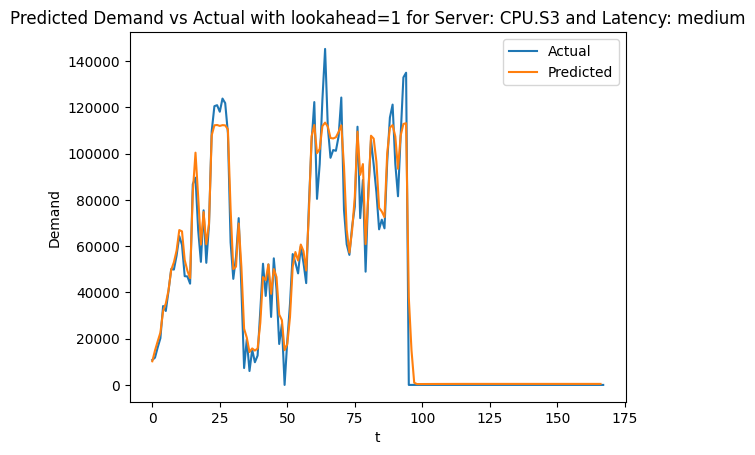

3


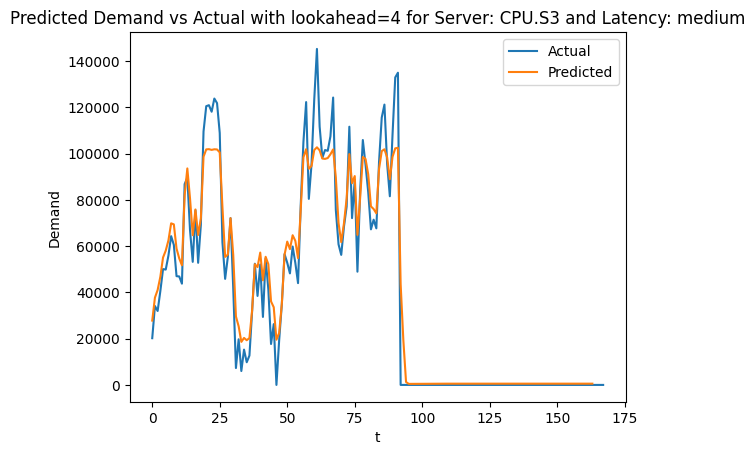

6


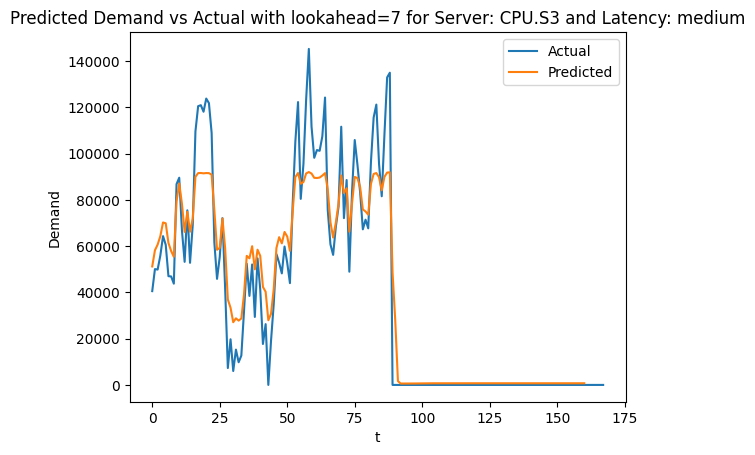

9


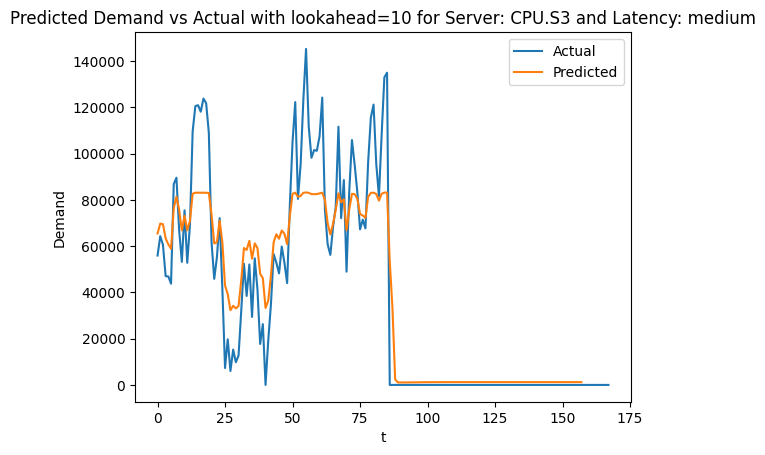

CPU.S3 low
EPOCH 1, Loss: 293.214

EPOCH 2, Loss: 127.756

EPOCH 3, Loss: 109.102

EPOCH 4, Loss: 104.165

EPOCH 5, Loss: 102.693

EPOCH 6, Loss: 101.776

EPOCH 7, Loss: 101.038

EPOCH 8, Loss: 100.410

EPOCH 9, Loss: 99.879

EPOCH 10, Loss: 99.425

R2: 0.739700436592102
0


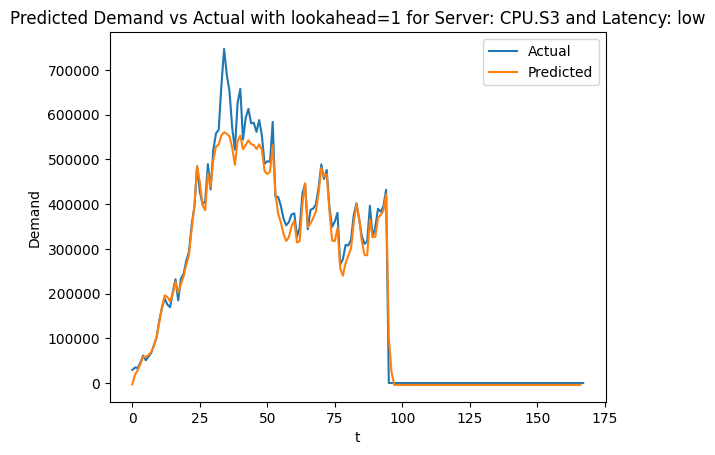

3


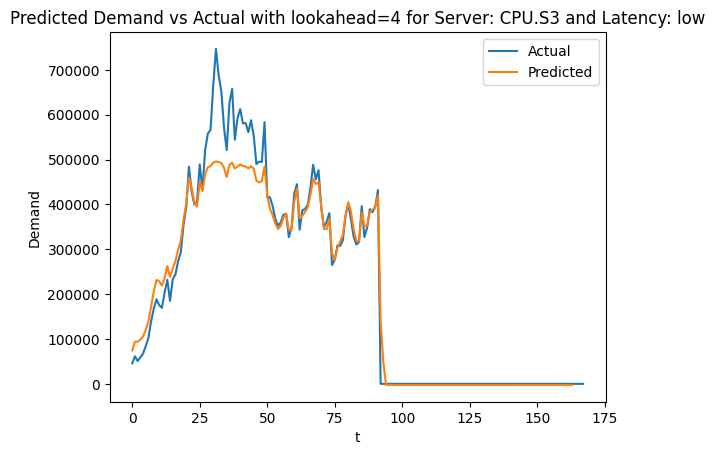

6


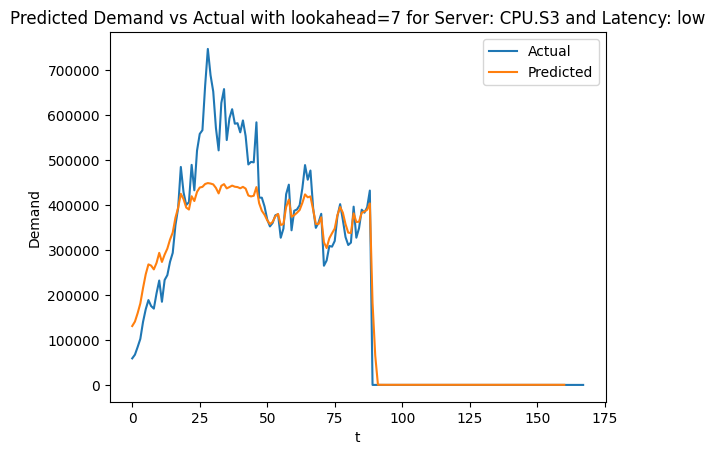

9


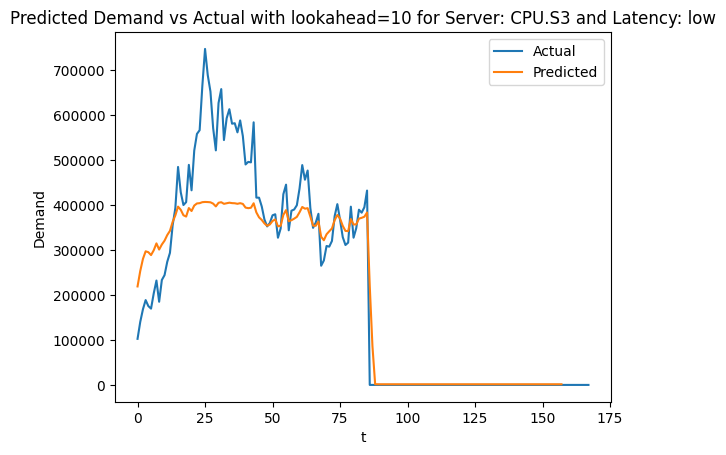

CPU.S4 high
EPOCH 1, Loss: 324.633

EPOCH 2, Loss: 114.340

EPOCH 3, Loss: 88.465

EPOCH 4, Loss: 83.263

EPOCH 5, Loss: 80.507

EPOCH 6, Loss: 79.300

EPOCH 7, Loss: 78.572

EPOCH 8, Loss: 78.021

EPOCH 9, Loss: 77.588

EPOCH 10, Loss: 77.121

R2: 0.6806920766830444
0


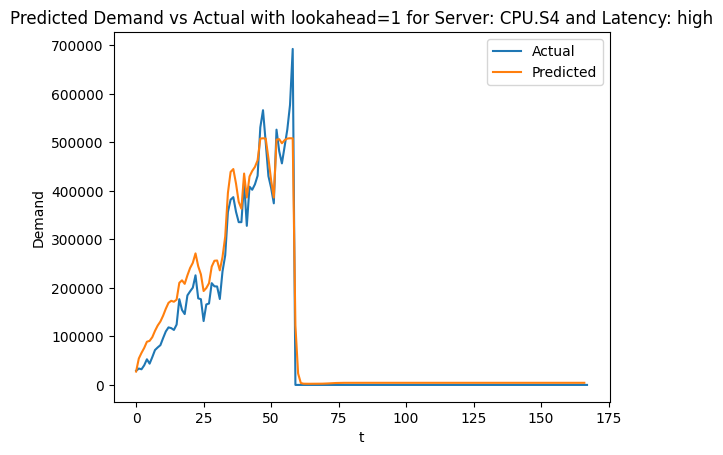

3


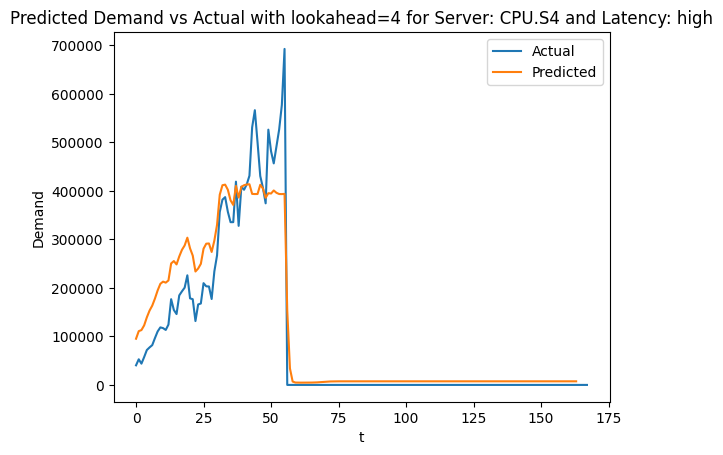

6


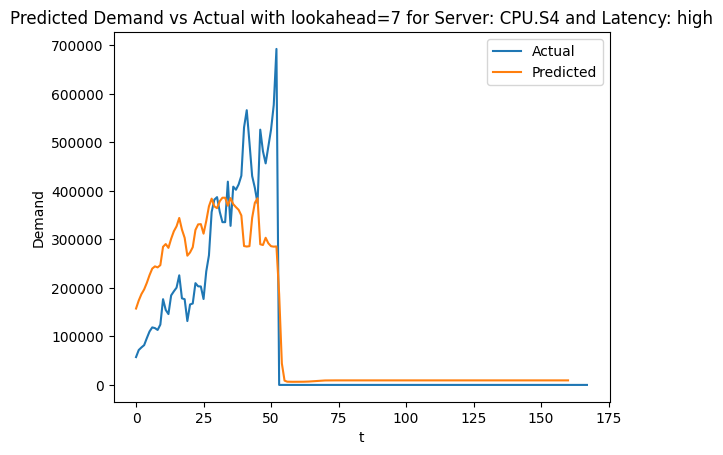

9


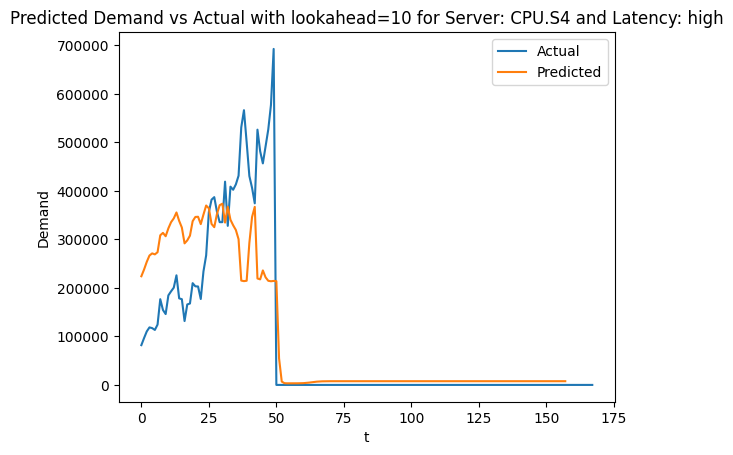

CPU.S4 medium
EPOCH 1, Loss: 319.129

EPOCH 2, Loss: 95.464

EPOCH 3, Loss: 83.955

EPOCH 4, Loss: 80.884

EPOCH 5, Loss: 79.275

EPOCH 6, Loss: 78.129

EPOCH 7, Loss: 77.251

EPOCH 8, Loss: 76.599

EPOCH 9, Loss: 76.146

EPOCH 10, Loss: 75.728

R2: 0.6547527313232422
0


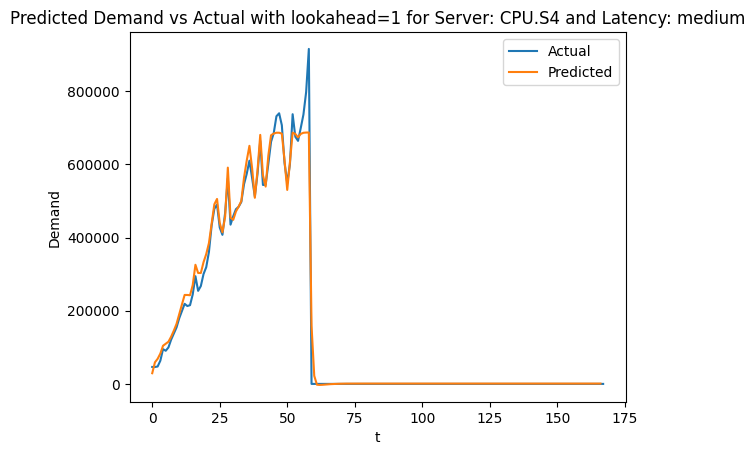

3


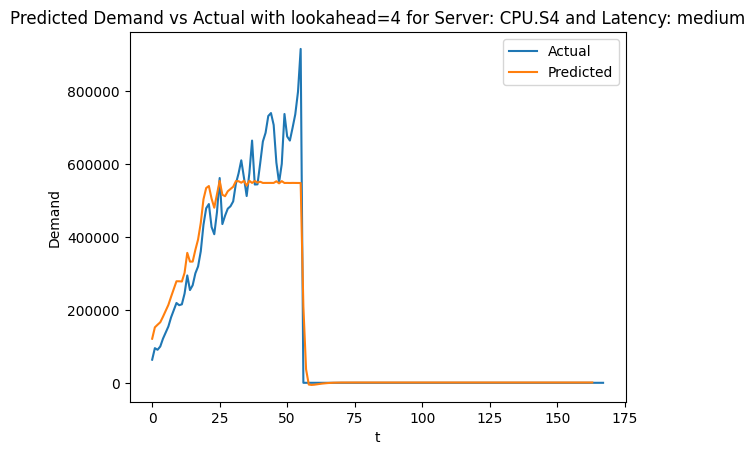

6


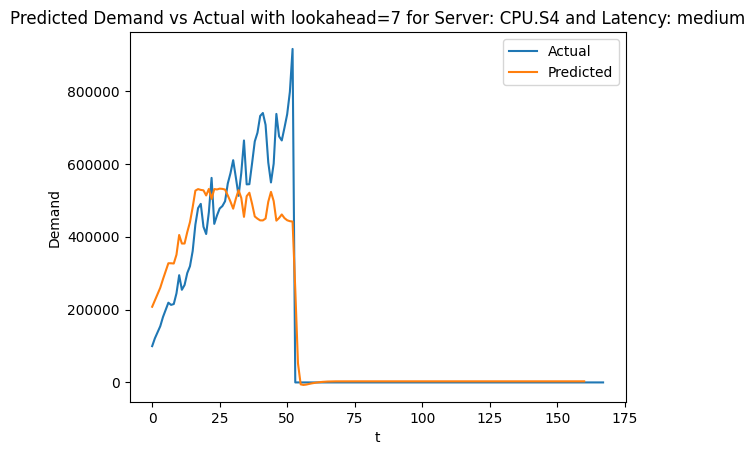

9


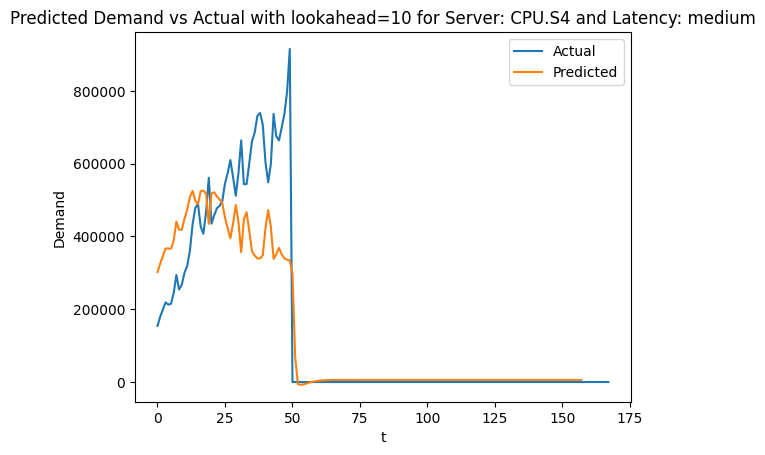

CPU.S4 low
EPOCH 1, Loss: 325.949

EPOCH 2, Loss: 133.924

EPOCH 3, Loss: 90.733

EPOCH 4, Loss: 84.957

EPOCH 5, Loss: 82.158

EPOCH 6, Loss: 80.681

EPOCH 7, Loss: 79.883

EPOCH 8, Loss: 78.963

EPOCH 9, Loss: 78.478

EPOCH 10, Loss: 77.997

R2: 0.7071256637573242
0


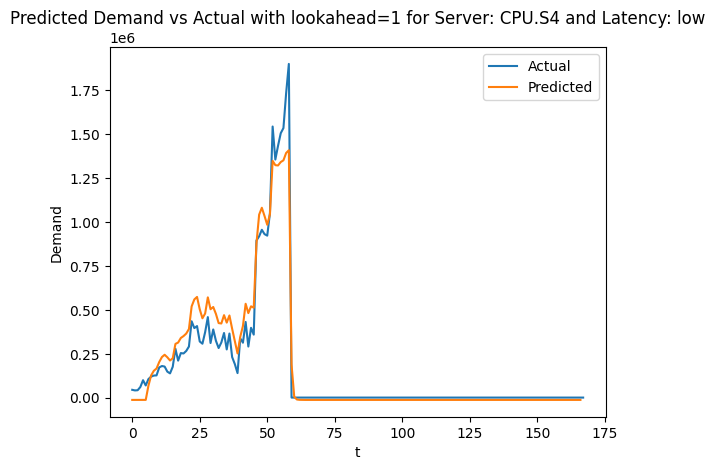

3


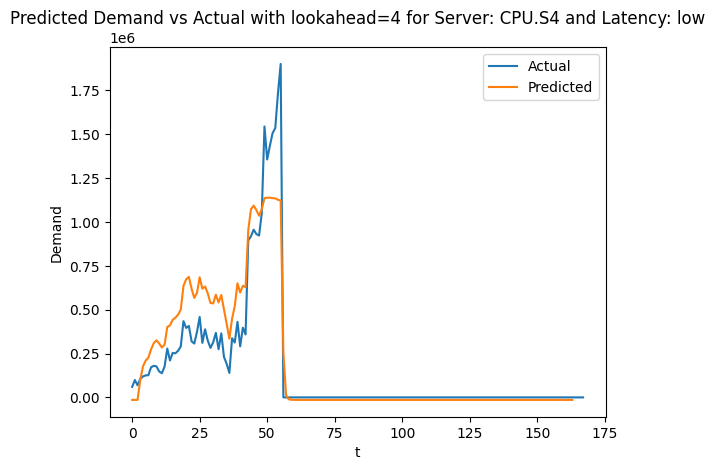

6


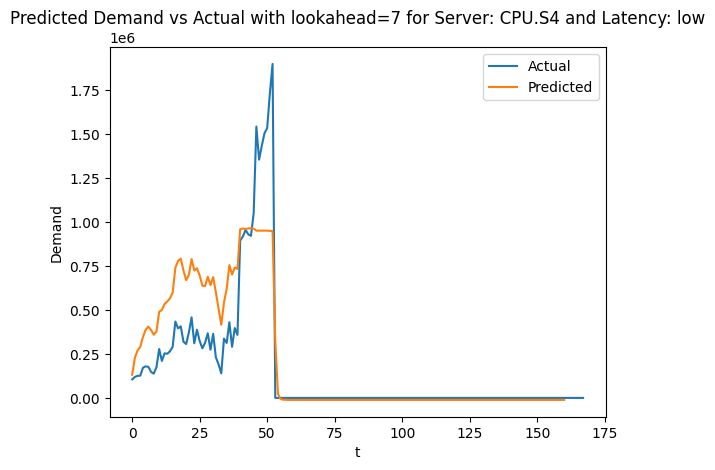

9


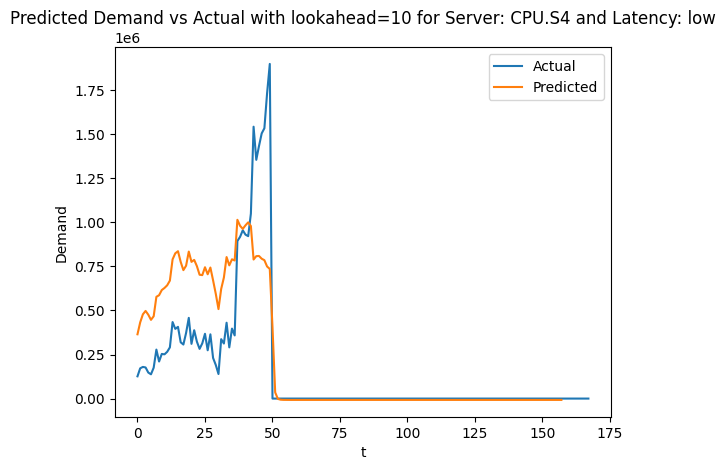

GPU.S1 high
EPOCH 1, Loss: 350.951

EPOCH 2, Loss: 126.948

EPOCH 3, Loss: 103.613

EPOCH 4, Loss: 95.350

EPOCH 5, Loss: 91.374

EPOCH 6, Loss: 88.369

EPOCH 7, Loss: 86.374

EPOCH 8, Loss: 84.815

EPOCH 9, Loss: 83.473

EPOCH 10, Loss: 82.399

R2: 0.7693300843238831
0


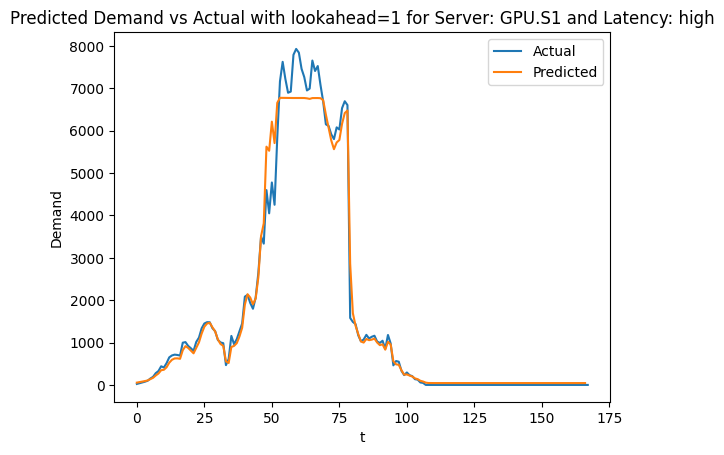

3


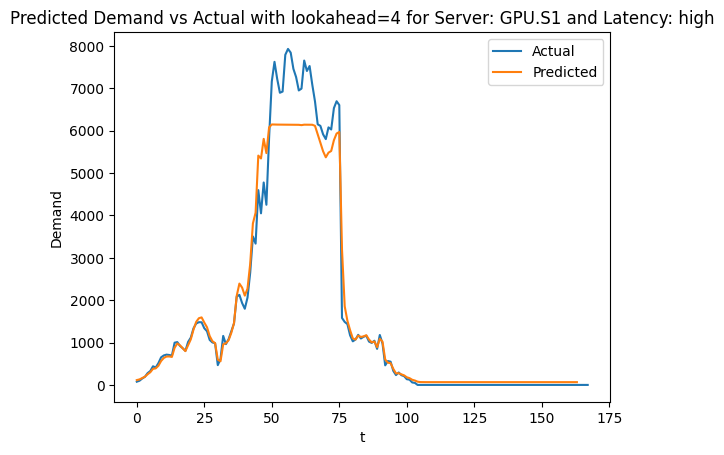

6


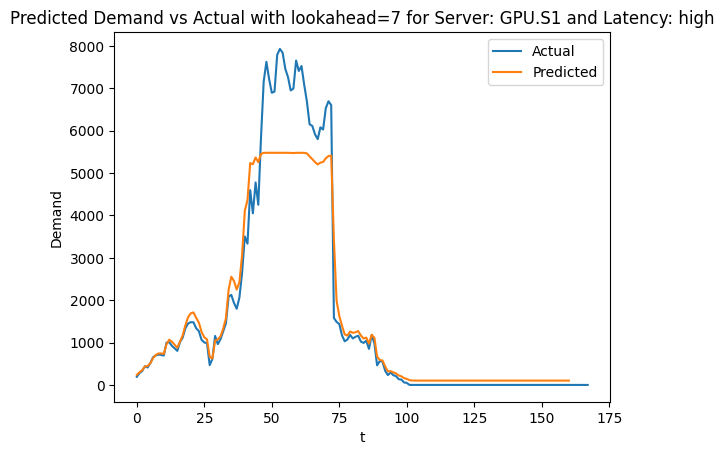

9


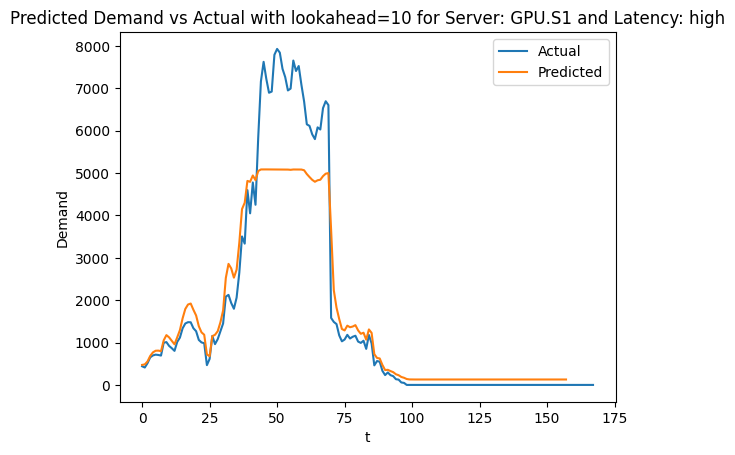

GPU.S1 medium
EPOCH 1, Loss: 293.968

EPOCH 2, Loss: 112.914

EPOCH 3, Loss: 85.499

EPOCH 4, Loss: 78.645

EPOCH 5, Loss: 75.219

EPOCH 6, Loss: 73.639

EPOCH 7, Loss: 72.686

EPOCH 8, Loss: 71.980

EPOCH 9, Loss: 71.393

EPOCH 10, Loss: 70.887

R2: 0.7831475734710693
0


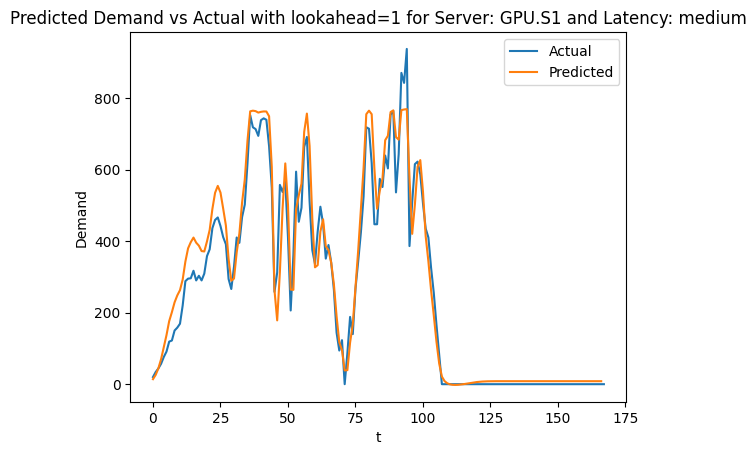

3


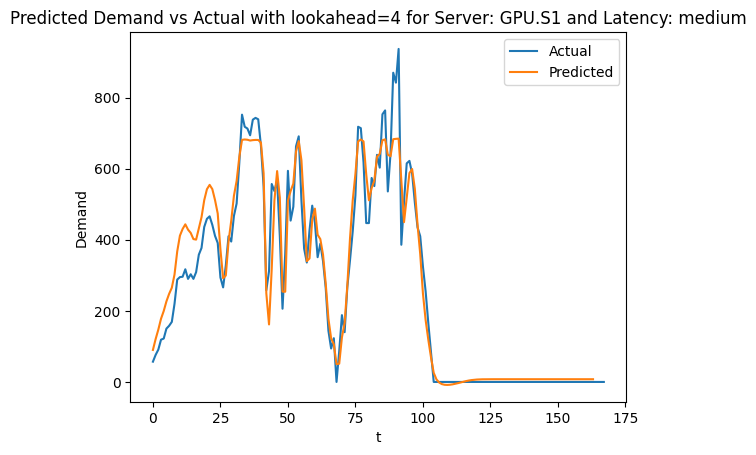

6


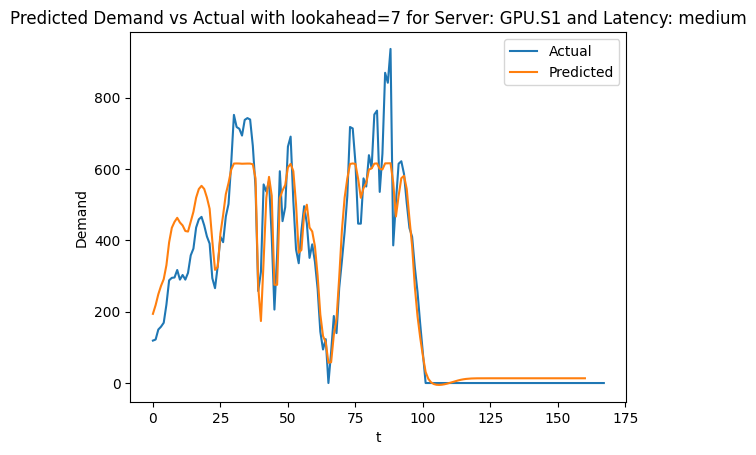

9


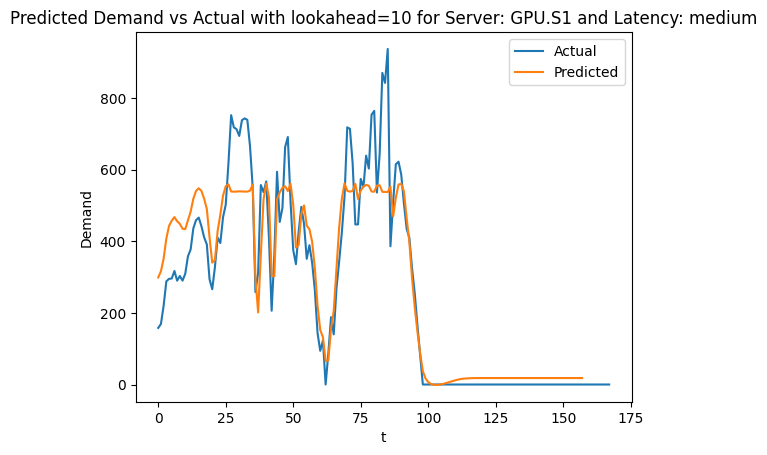

GPU.S1 low
EPOCH 1, Loss: 302.103

EPOCH 2, Loss: 106.882

EPOCH 3, Loss: 80.139

EPOCH 4, Loss: 74.340

EPOCH 5, Loss: 70.486

EPOCH 6, Loss: 68.799

EPOCH 7, Loss: 67.862

EPOCH 8, Loss: 67.174

EPOCH 9, Loss: 66.632

EPOCH 10, Loss: 66.176

R2: 0.809121310710907
0


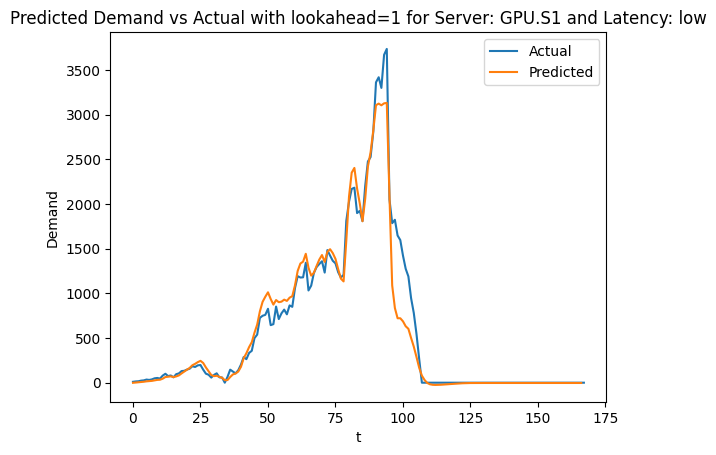

3


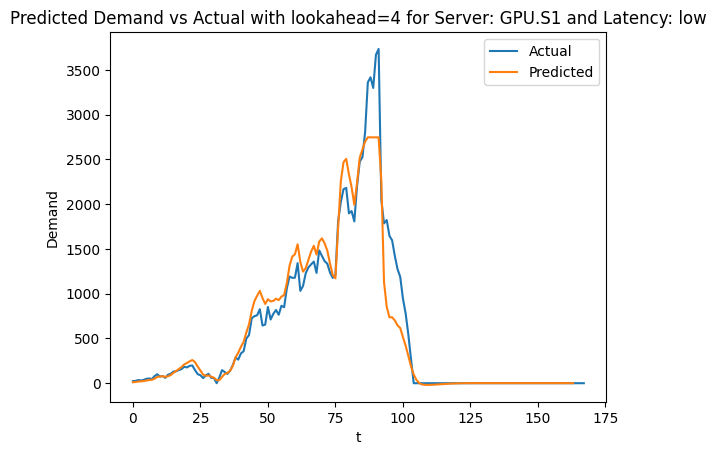

6


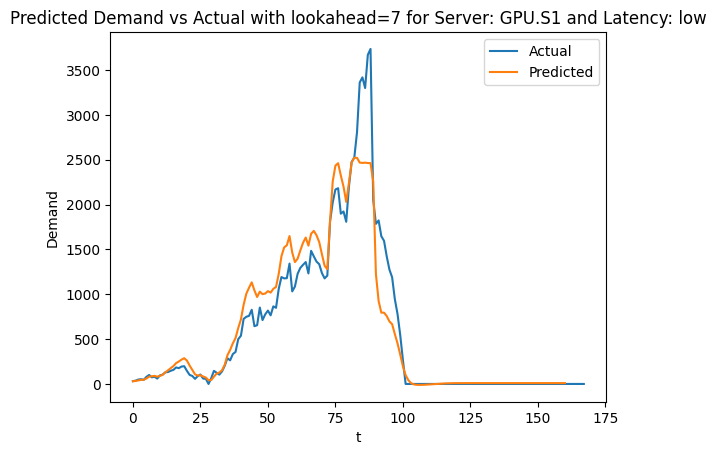

9


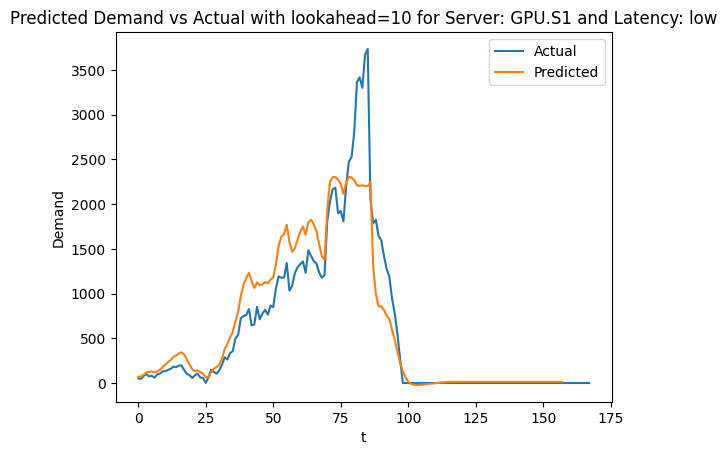

GPU.S2 high
EPOCH 1, Loss: 293.310

EPOCH 2, Loss: 124.241

EPOCH 3, Loss: 106.339

EPOCH 4, Loss: 100.989

EPOCH 5, Loss: 98.541

EPOCH 6, Loss: 97.046

EPOCH 7, Loss: 95.964

EPOCH 8, Loss: 95.131

EPOCH 9, Loss: 94.475

EPOCH 10, Loss: 93.945

R2: 0.7084590196609497
0


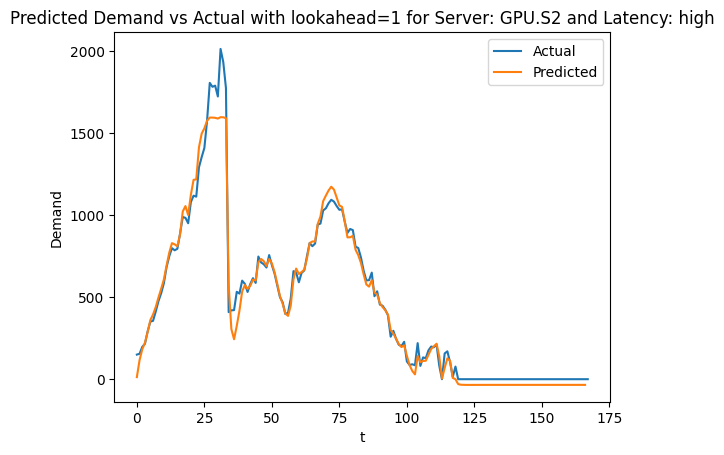

3


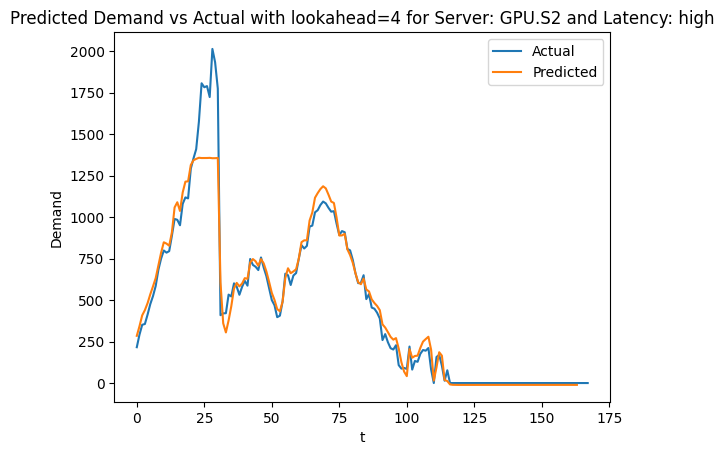

6


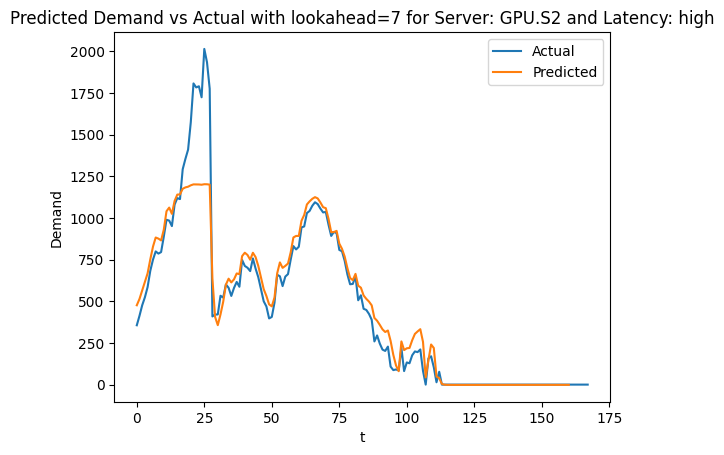

9


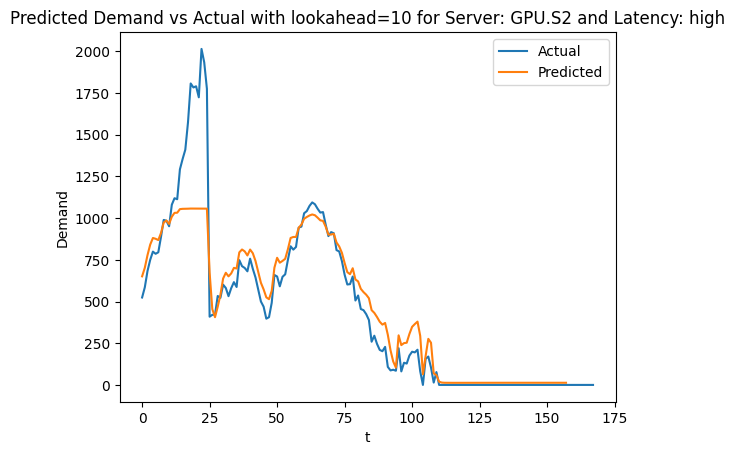

GPU.S2 medium
EPOCH 1, Loss: 315.330

EPOCH 2, Loss: 148.561

EPOCH 3, Loss: 127.356

EPOCH 4, Loss: 116.371

EPOCH 5, Loss: 110.428

EPOCH 6, Loss: 107.214

EPOCH 7, Loss: 105.183

EPOCH 8, Loss: 103.690

EPOCH 9, Loss: 102.482

EPOCH 10, Loss: 101.437

R2: 0.7254118919372559
0


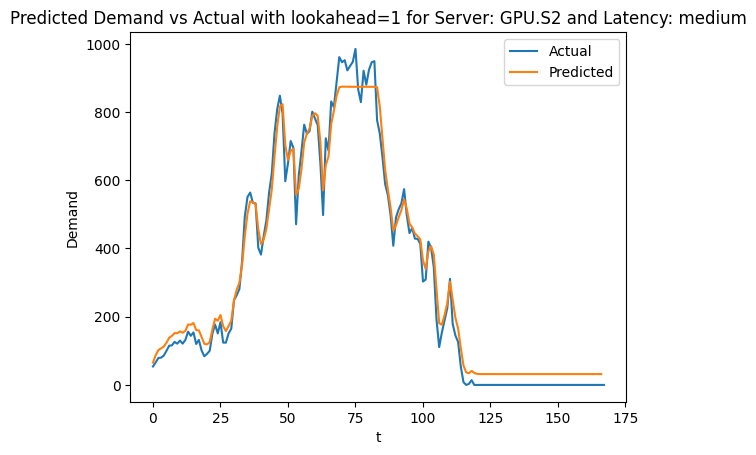

3


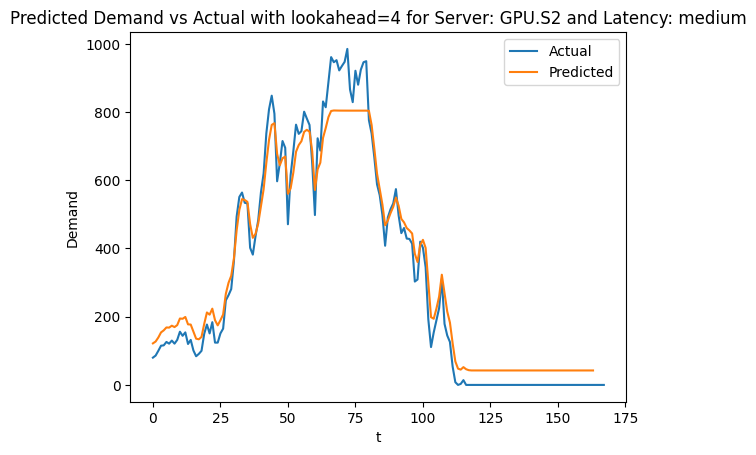

6


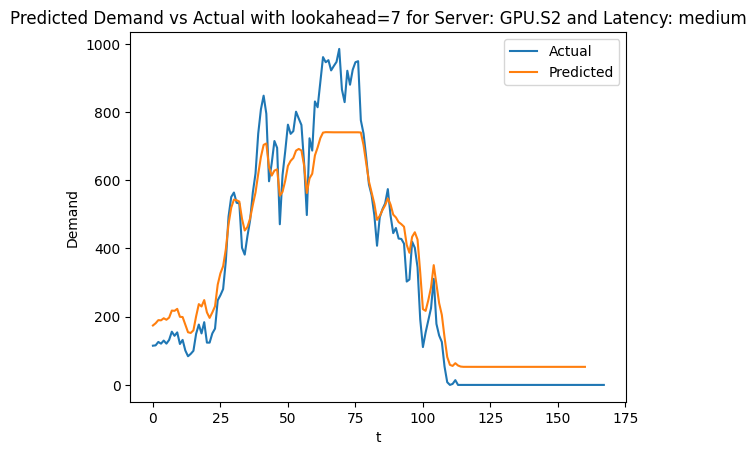

9


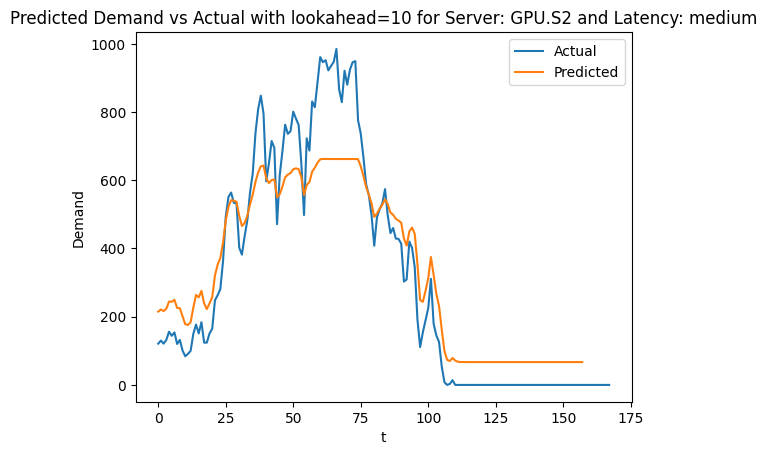

GPU.S2 low
EPOCH 1, Loss: 356.547

EPOCH 2, Loss: 157.448

EPOCH 3, Loss: 134.424

EPOCH 4, Loss: 121.815

EPOCH 5, Loss: 115.765

EPOCH 6, Loss: 112.483

EPOCH 7, Loss: 110.479

EPOCH 8, Loss: 109.252

EPOCH 9, Loss: 108.362

EPOCH 10, Loss: 107.646

R2: 0.7848290205001831
0


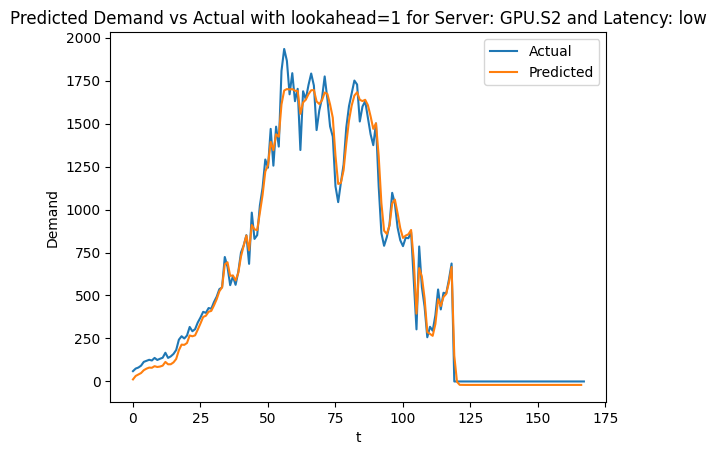

3


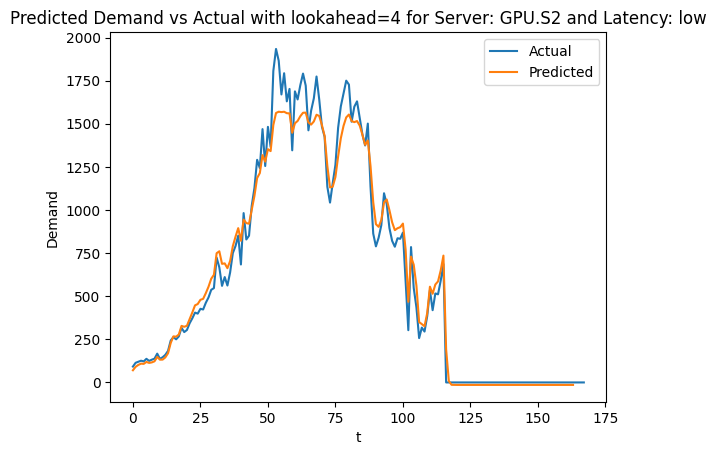

6


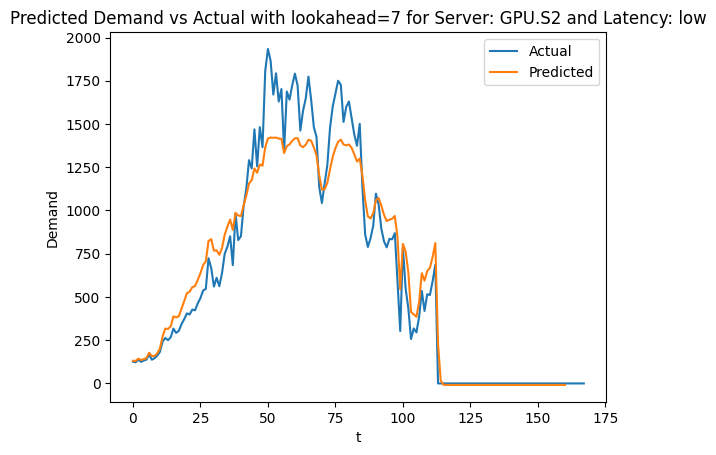

9


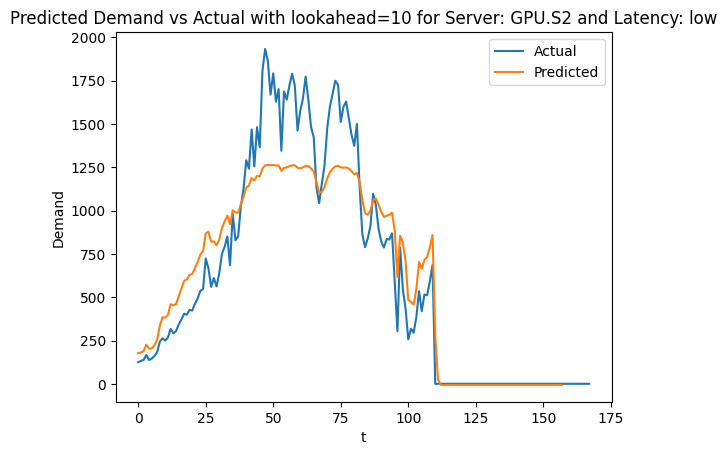

GPU.S3 high
EPOCH 1, Loss: 298.767

EPOCH 2, Loss: 109.265

EPOCH 3, Loss: 96.011

EPOCH 4, Loss: 90.768

EPOCH 5, Loss: 88.068

EPOCH 6, Loss: 86.246

EPOCH 7, Loss: 84.845

EPOCH 8, Loss: 83.920

EPOCH 9, Loss: 83.091

EPOCH 10, Loss: 82.405

R2: 0.7232010364532471
0


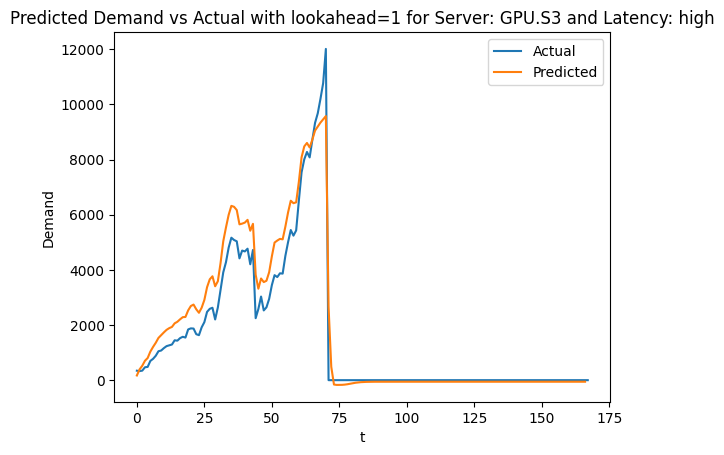

3


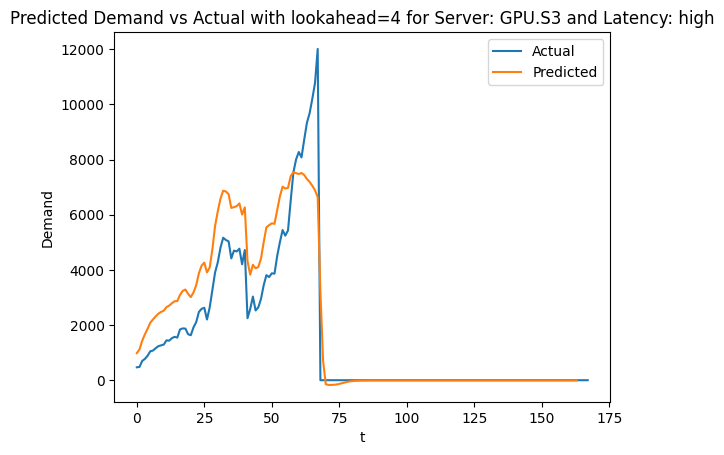

6


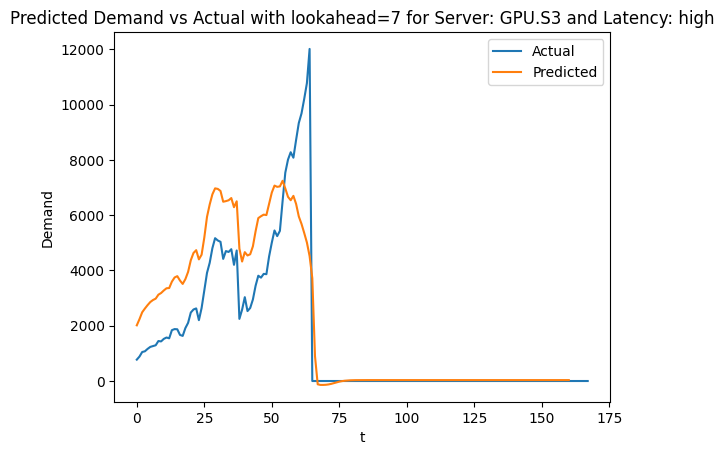

9


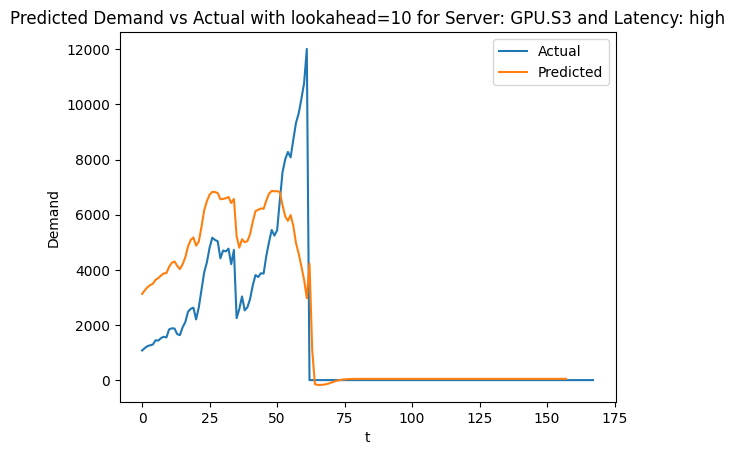

GPU.S3 medium
EPOCH 1, Loss: 311.850

EPOCH 2, Loss: 111.017

EPOCH 3, Loss: 89.181

EPOCH 4, Loss: 83.853

EPOCH 5, Loss: 81.672

EPOCH 6, Loss: 79.934

EPOCH 7, Loss: 78.529

EPOCH 8, Loss: 77.342

EPOCH 9, Loss: 76.185

EPOCH 10, Loss: 74.732

R2: 0.7599154114723206
0


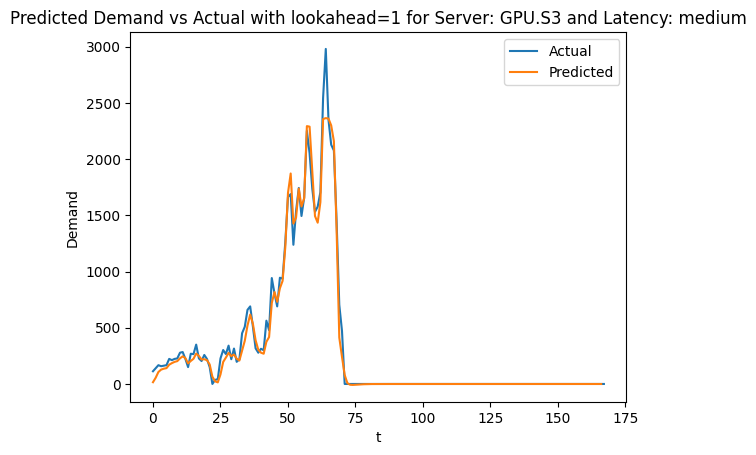

3


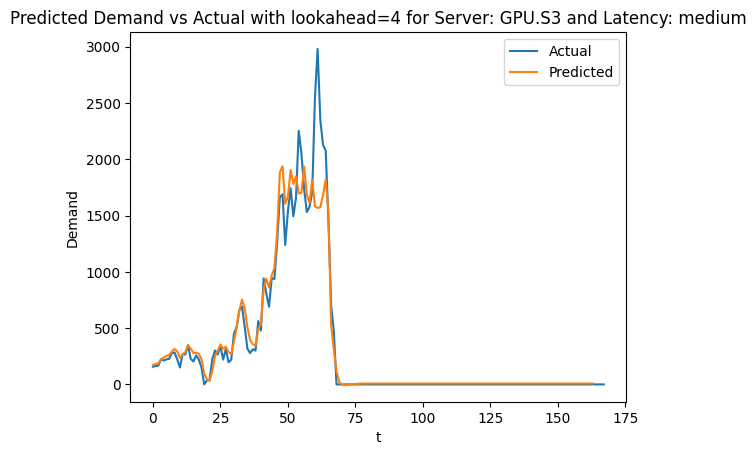

6


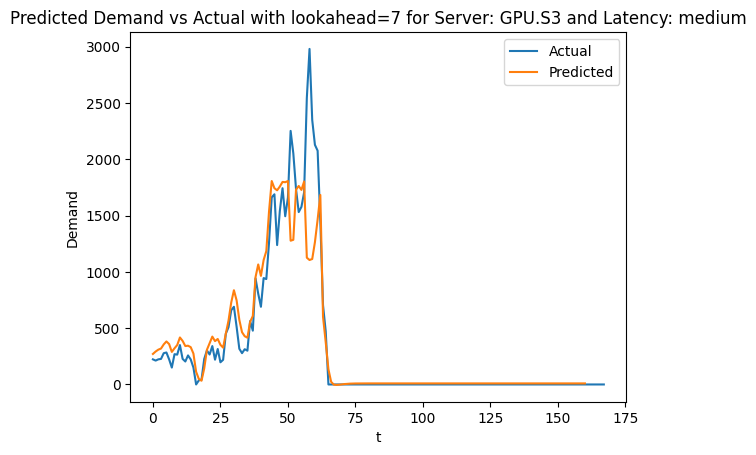

9


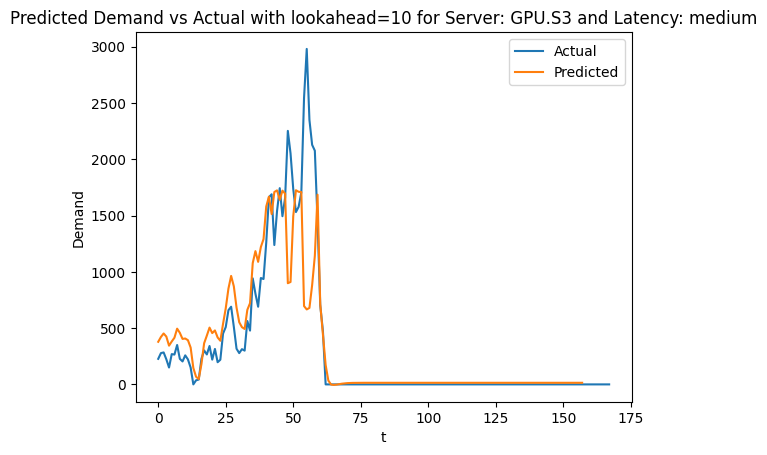

GPU.S3 low
EPOCH 1, Loss: 315.375

EPOCH 2, Loss: 144.709

EPOCH 3, Loss: 84.925

EPOCH 4, Loss: 80.683

EPOCH 5, Loss: 78.616

EPOCH 6, Loss: 76.848

EPOCH 7, Loss: 75.720

EPOCH 8, Loss: 74.699

EPOCH 9, Loss: 73.773

EPOCH 10, Loss: 71.540

R2: 0.7567124962806702
0


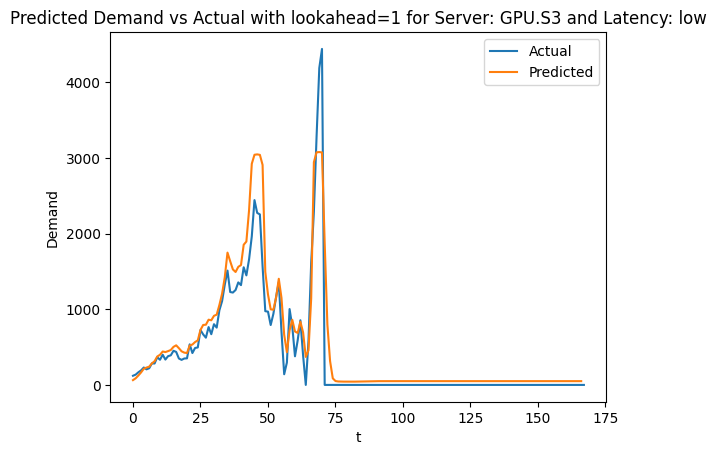

3


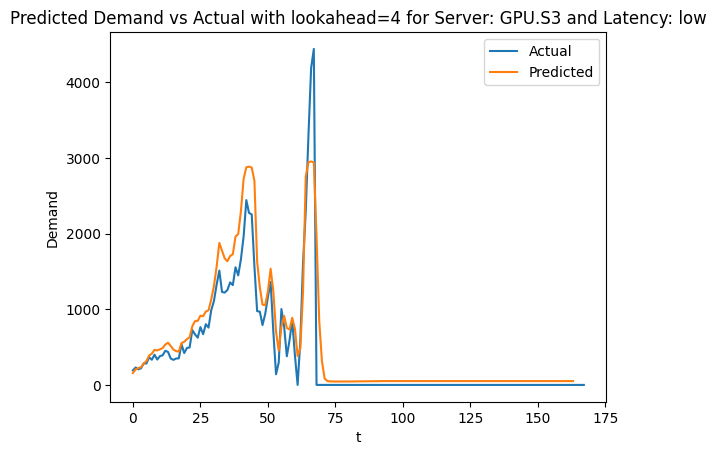

6


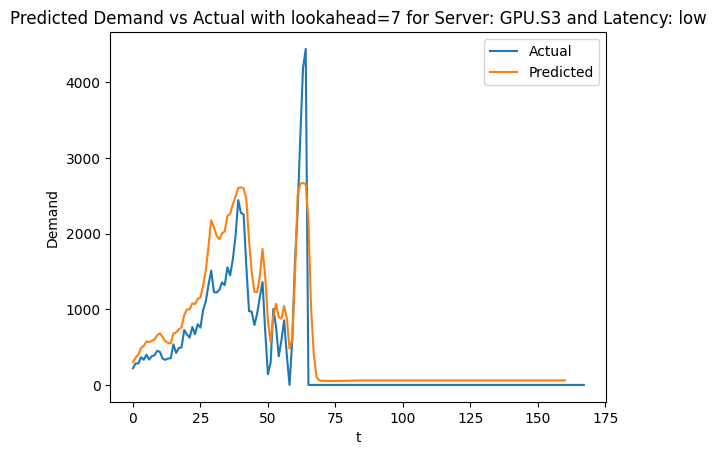

9


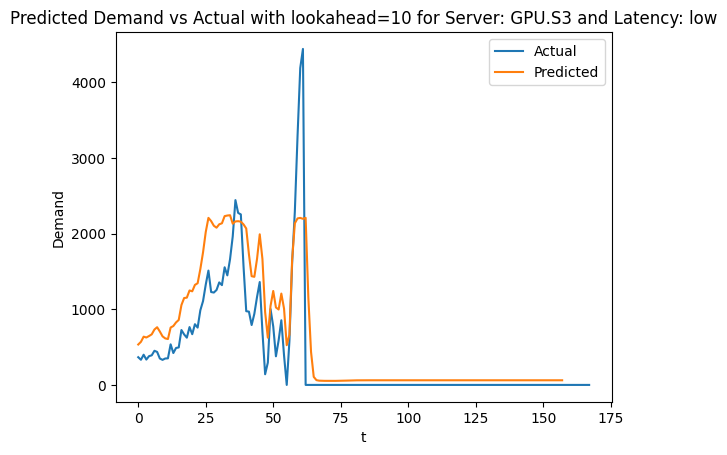

In [34]:
from torcheval.metrics import R2Score
from torch.utils.data import DataLoader


demand, _ , _ , _= load_problem_data() ##pd.read_csv('./data/demand.csv')

lookback = 25
lookahead = 10

seeds = range(0,10000,100)

test_seeds = range(10000,11000,100)

batch_size = 16 


for server in get_known("server_generation"):
    for latency in get_known("latency_sensitivity"):

        latency_sensitivity = latency
        server_type = server

        print(server_type , latency_sensitivity )

        datalist = [getDataNumpyArray(seed) for seed in seeds] 
        train_dataset = TimeSeriesDataset(datalist)

        

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)



        

        ## create model 
        model = LSTM(1, 40, 10, lookahead)
        model.to(device)

        learning_rate = 0.0001

        num_epochs = 10

        loss_function = nn.MSELoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):

            train_one_epoch()


        metric = R2Score()
        for test_seed in test_seeds:
            test_X, test_Y = getDataNumpyArray(test_seed)
            

            with torch.no_grad():

                predicted = model(test_X.to(device)).to("cpu")
                test_Y = torch.squeeze(test_Y)
                # test_Y = torch.from_numpy(test_Y)

              

                
                for i in range(lookahead):

                    
                    metric.update(predicted[:,i],test_Y[:,i])

        print(f"R2: {metric.compute()}")


        test_seed = 11001
        test_X, test_Y = getDataNumpyArray(test_seed)

        with torch.no_grad():

            predicted = model(test_X.to(device)).to("cpu").numpy()


        real_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
        real_value_dummies[:, :lookahead] = np.squeeze(test_Y)
        real_value_dummies = scaler.inverse_transform(real_value_dummies)

        scaled_test_Y = dc(real_value_dummies[:, :lookahead])


        predicted_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
        predicted_value_dummies[:, :lookahead] = np.squeeze(predicted)
        predicted_value_dummies = scaler.inverse_transform(predicted_value_dummies)

        scaled_predictions = dc(predicted_value_dummies[:, :lookahead])


        for i in range(0,lookahead,3):
            print(i)
            predicted_i = scaled_predictions[:,i]
            y_i = scaled_test_Y[:,i]

            plt.title(f"Predicted Demand vs Actual with lookahead={i+1} for Server: {server_type} and Latency: {latency_sensitivity}")

            plt.plot(y_i, label='Actual')
            plt.plot(predicted_i[i+1:], label='Predicted')
            plt.xlabel('t')
            plt.ylabel('Demand')
            plt.legend()
            plt.show()
            

            



        


        PATH = f"lstm_models/{server_type}_{latency}"
        torch.save(model.state_dict(), PATH)


        

0


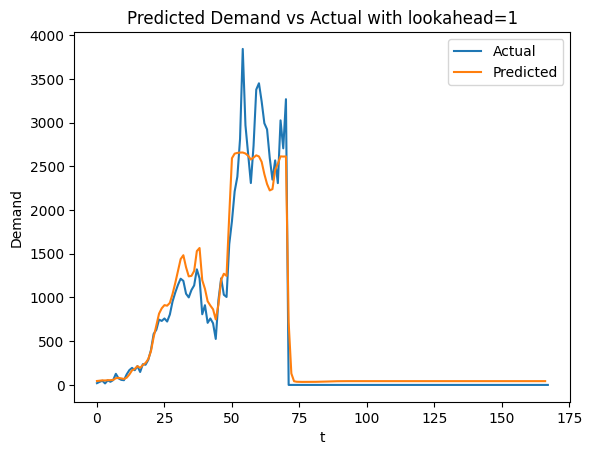

3


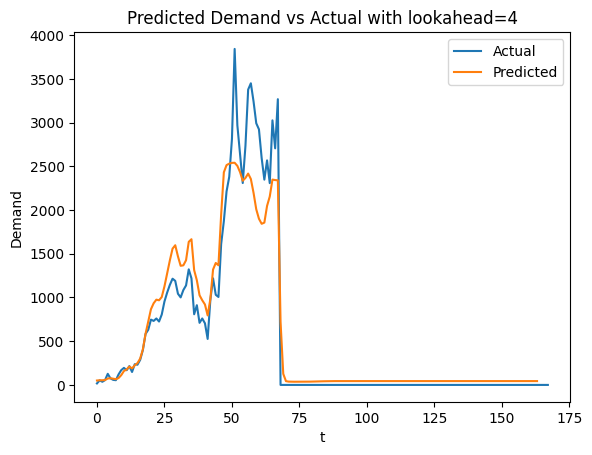

6


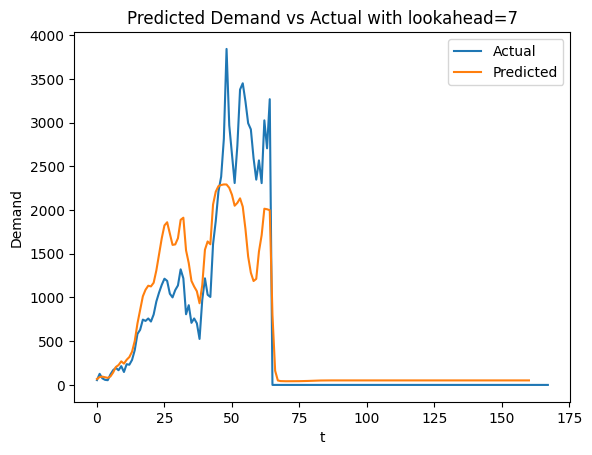

9


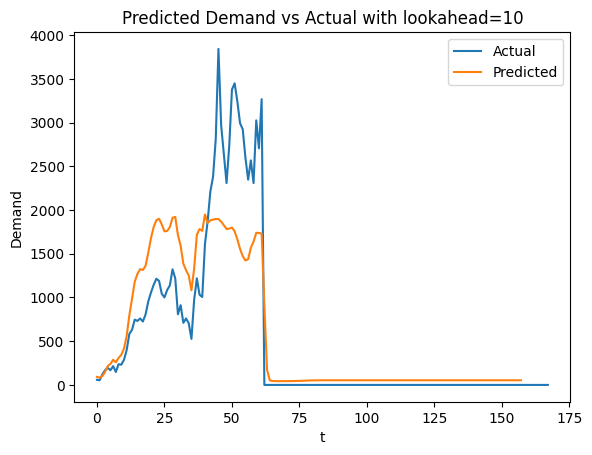

In [35]:
test_seed = 100

test_X, test_Y = getDataNumpyArray(test_seed)

with torch.no_grad():

    predicted = model(test_X.to(device)).to("cpu").numpy()


real_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
real_value_dummies[:, :lookahead] = np.squeeze(test_Y)
real_value_dummies = scaler.inverse_transform(real_value_dummies)

scaled_test_Y = dc(real_value_dummies[:, :lookahead])


predicted_value_dummies = np.zeros((test_X.shape[0], lookback+lookahead))
predicted_value_dummies[:, :lookahead] = np.squeeze(predicted)
predicted_value_dummies = scaler.inverse_transform(predicted_value_dummies)

scaled_predictions = dc(predicted_value_dummies[:, :lookahead])


for i in range(0,lookahead,3):
    print(i)
    predicted_i = scaled_predictions[:,i]
    y_i = scaled_test_Y[:,i]

    plt.title(f"Predicted Demand vs Actual with lookahead={i+1}")

    plt.plot(y_i, label='Actual')
    plt.plot(predicted_i[i+1:], label='Predicted')
    plt.xlabel('t')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

